# Solving TSP with Simulated Annealing: Part 2

This notebook includes simulation and plotting for `a280.tsp`:

- Initial acceptance rate $\eta$ vs. $T_0$
- Visualization of cooling schedules (analytic)
- Convergence properties by parameter values for linear, geometric and log cooling schemes
- Comparison of three cooling schemes and boxplot with statistical tests
- Additional analytical plots: Bolzman distribution

In [13]:
from functools import reduce
from operator import mul
import numpy as np
import logging
from os.path import exists
from os import mkdir
import matplotlib.pyplot as plt
import matplotlib as mpl
from pickle import load, dump
import seaborn as sns
import pandas as pd
from scipy import stats

from assignment.util import *
from assignment.TSP import *
from assignment.cooling import *
from assignment.SAMinimizer import *

logging.basicConfig(level = logging.INFO)

f64 = np.float64
i32 = np.int32
i64 = np.int64

mpl.rcParams["figure.dpi"] = 600
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11

SECONDARY_SAVE_DIR = "./save_data(2)"
if not exists(SECONDARY_SAVE_DIR):
    mkdir(SECONDARY_SAVE_DIR)
    

def save_path_2(filename):
    return f"{SECONDARY_SAVE_DIR}/filename"

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [14]:
def info(msg):
        
    """
    TODO:
    
    """
    
    print(f"[INFO] {msg}")

In [15]:
def generate_multidim_rngs(seed, *args):
        
    """
    TODO:
    
    """
    
    flatlen = reduce(mul, args, 1)
    rngs = generate_rngs(flatlen, seed = seed)
    rngs = np.array(rngs, dtype = np.object)
    rngs = rngs.reshape(args)
    return rngs

In [16]:
def save_path_2(filename):
        
    """
    TODO:
    
    """
    
    return f"{SECONDARY_SAVE_DIR}/{filename}"

In [17]:
def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
        
    """
    TODO:
    
    """
    
    acceptance_rates = np.full(batch_size, np.float64("nan"))
    min_costs = np.full(batch_size, np.float64("nan"))
    node_count = sa_system.delta_cost.D.shape[0]
    for i in range(batch_size):
        X0 = np.random.permutation(node_count)
        sa_system.run(chain_length, T_initial, X0, *args)
        min_costs[i] = sa_system.min_cost
        acceptance_rates[i] = np.float64(sa_system.acceptance_count)/chain_length
        sa_system.reset()
        
    return min_costs, acceptance_rates

In [18]:
"""
TODO:

"""
    
DEFAULT_TRANSITIONS = (random_two_opt_transition, Lin2opt)
transition, state_constructor = DEFAULT_TRANSITIONS

cost_func, dcost_func = COST_FUNCTION_PAIRS[1]
node_count = first(cost_func.D.shape)
assert node_count == 280 == first(dcost_func.D.shape)

## Initial Acceptance Rate $\eta$ vs. $T_0$ for `a280.tsp`

In [178]:
"""
TODO:

"""

# outer loop of parameter sweep
chain_lengths = np.linspace(1000, 5000, 5, dtype = np.int32)

cost_probing = CostProbing.LATEST_GLOBAL_OPTIMUM
stopping = StoppingCriterion.MKOV_CHAIN_COUNT
chain_count = 1
# does not matter as we are running only one chain, no cooling required
cooling = GeometricCoolingSchedule(0.5)


root_N = np.sqrt(node_count)
_start_c_value = 10
_end_c_value = 30
c_values = np.arange(_start_c_value, _end_c_value, dtype = f64)
#inner loop of parameter sweep
T0_values = c_values * root_N

args = (cost_func, stopping, cost_probing, chain_count)

batch_size = 20

Ni = len(chain_lengths)
Nj = len(T0_values)
# for chain_len in chain_lengths
#     for T0 in T0_values
#         run_batch()


rngs = np.array([generate_rngs(Nj, seed = 0xc0ffee_1337) for _ in range(Ni)], dtype = np.object)
    

npz_filename = "a280_proto_param_sweep.npz"
npz_filepath = save_path_2(npz_filename)

acceptance_rates = np.full((Ni,Nj,batch_size), np.float64("nan"))

if not exists(npz_filepath):
    #     logging.info("Performing parameter sweeps...")
    print("[INFO]: Performing parameter sweeps...")
    for i,clen in enumerate(chain_lengths):
        #         logging.info(f"Done with {i} of {Ni} chain length values")
        print(f"[INFO]: Done with {i} of {Ni} chain length values")
        for j,T0 in enumerate(T0_values):
            system = SAMinimizer(transition, dcost_func, cooling, rngs[i][j].uniform, state_constructor)
            _, η_values = run_batch(system, batch_size, clen, T0, *args)
            assert η_values.shape == (batch_size,)
            acceptance_rates[i][j] = η_values
            
    np.savez(npz_filepath, acceptance_rates)
else:
    with np.load(npz_filepath) as save_data:
        acceptance_rates = save_data['arr_0']
        
mean_η_values = [np.mean(η_matrix, axis = 1) for η_matrix in acceptance_rates]
std_η_values = [np.std(η_matrix, axis = 1) for η_matrix in acceptance_rates]
print(mean_η_values[-1])

[0.7599625 0.7781125 0.7985375 0.8126875 0.82735   0.8392875 0.8488
 0.85685   0.8633875 0.8725875 0.8799375 0.8835125 0.889325  0.8927
 0.899875  0.9026625 0.905425  0.90855   0.91315   0.917275 ]


/var/folders/hg/g0dmwys902d4l16w6vd0n3qr0000gn/T/ipykernel_24372/1379248478.py:38: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rngs = np.array([generate_rngs(Nj, seed = 0xc0ffee_1337) for _ in range(Ni)], dtype = np.object)


In [181]:
def multiple_lines_plotter(simulated_data, title):
    
    """
    Plots mean acceptance rate and SD given the corresponting initial temperature 
    for different Markoc chain lenghts.
    
    """
    
    cost_func, dcost_func = COST_FUNCTION_PAIRS[1]
    node_count = first(cost_func.D.shape)
    
    root_N = np.sqrt(node_count)
    _start_c_value = 10
    _end_c_value = 30
    c_values = np.arange(_start_c_value, _end_c_value, dtype = f64)
    T0_values = c_values * root_N
    
    chain_lengths = np.linspace(1000, 5000, 5, dtype = np.int32)
    filename = simulated_data
    filepath = save_path_2(filename)
    
    acceptance_rates = np.load(filepath)['arr_0']
    
    plt.xlabel("$T_0$")
    plt.ylabel("Mean acceptance rate, $\eta$ and SD")
    for i,acc_rates in enumerate(acceptance_rates):
        clen = chain_lengths[i]
        mean_acc_rates = np.mean(acc_rates, axis = 1)
        std_acc_rates = np.std(acc_rates, axis = 1)
        plt.plot(T0_values, mean_acc_rates, label = f"Chain length = {clen}")
        plt.fill_between(T0_values, mean_acc_rates - std_acc_rates, mean_acc_rates + std_acc_rates, alpha = 0.3)
    plt.grid(alpha = 0.6)
    plt.legend()
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()

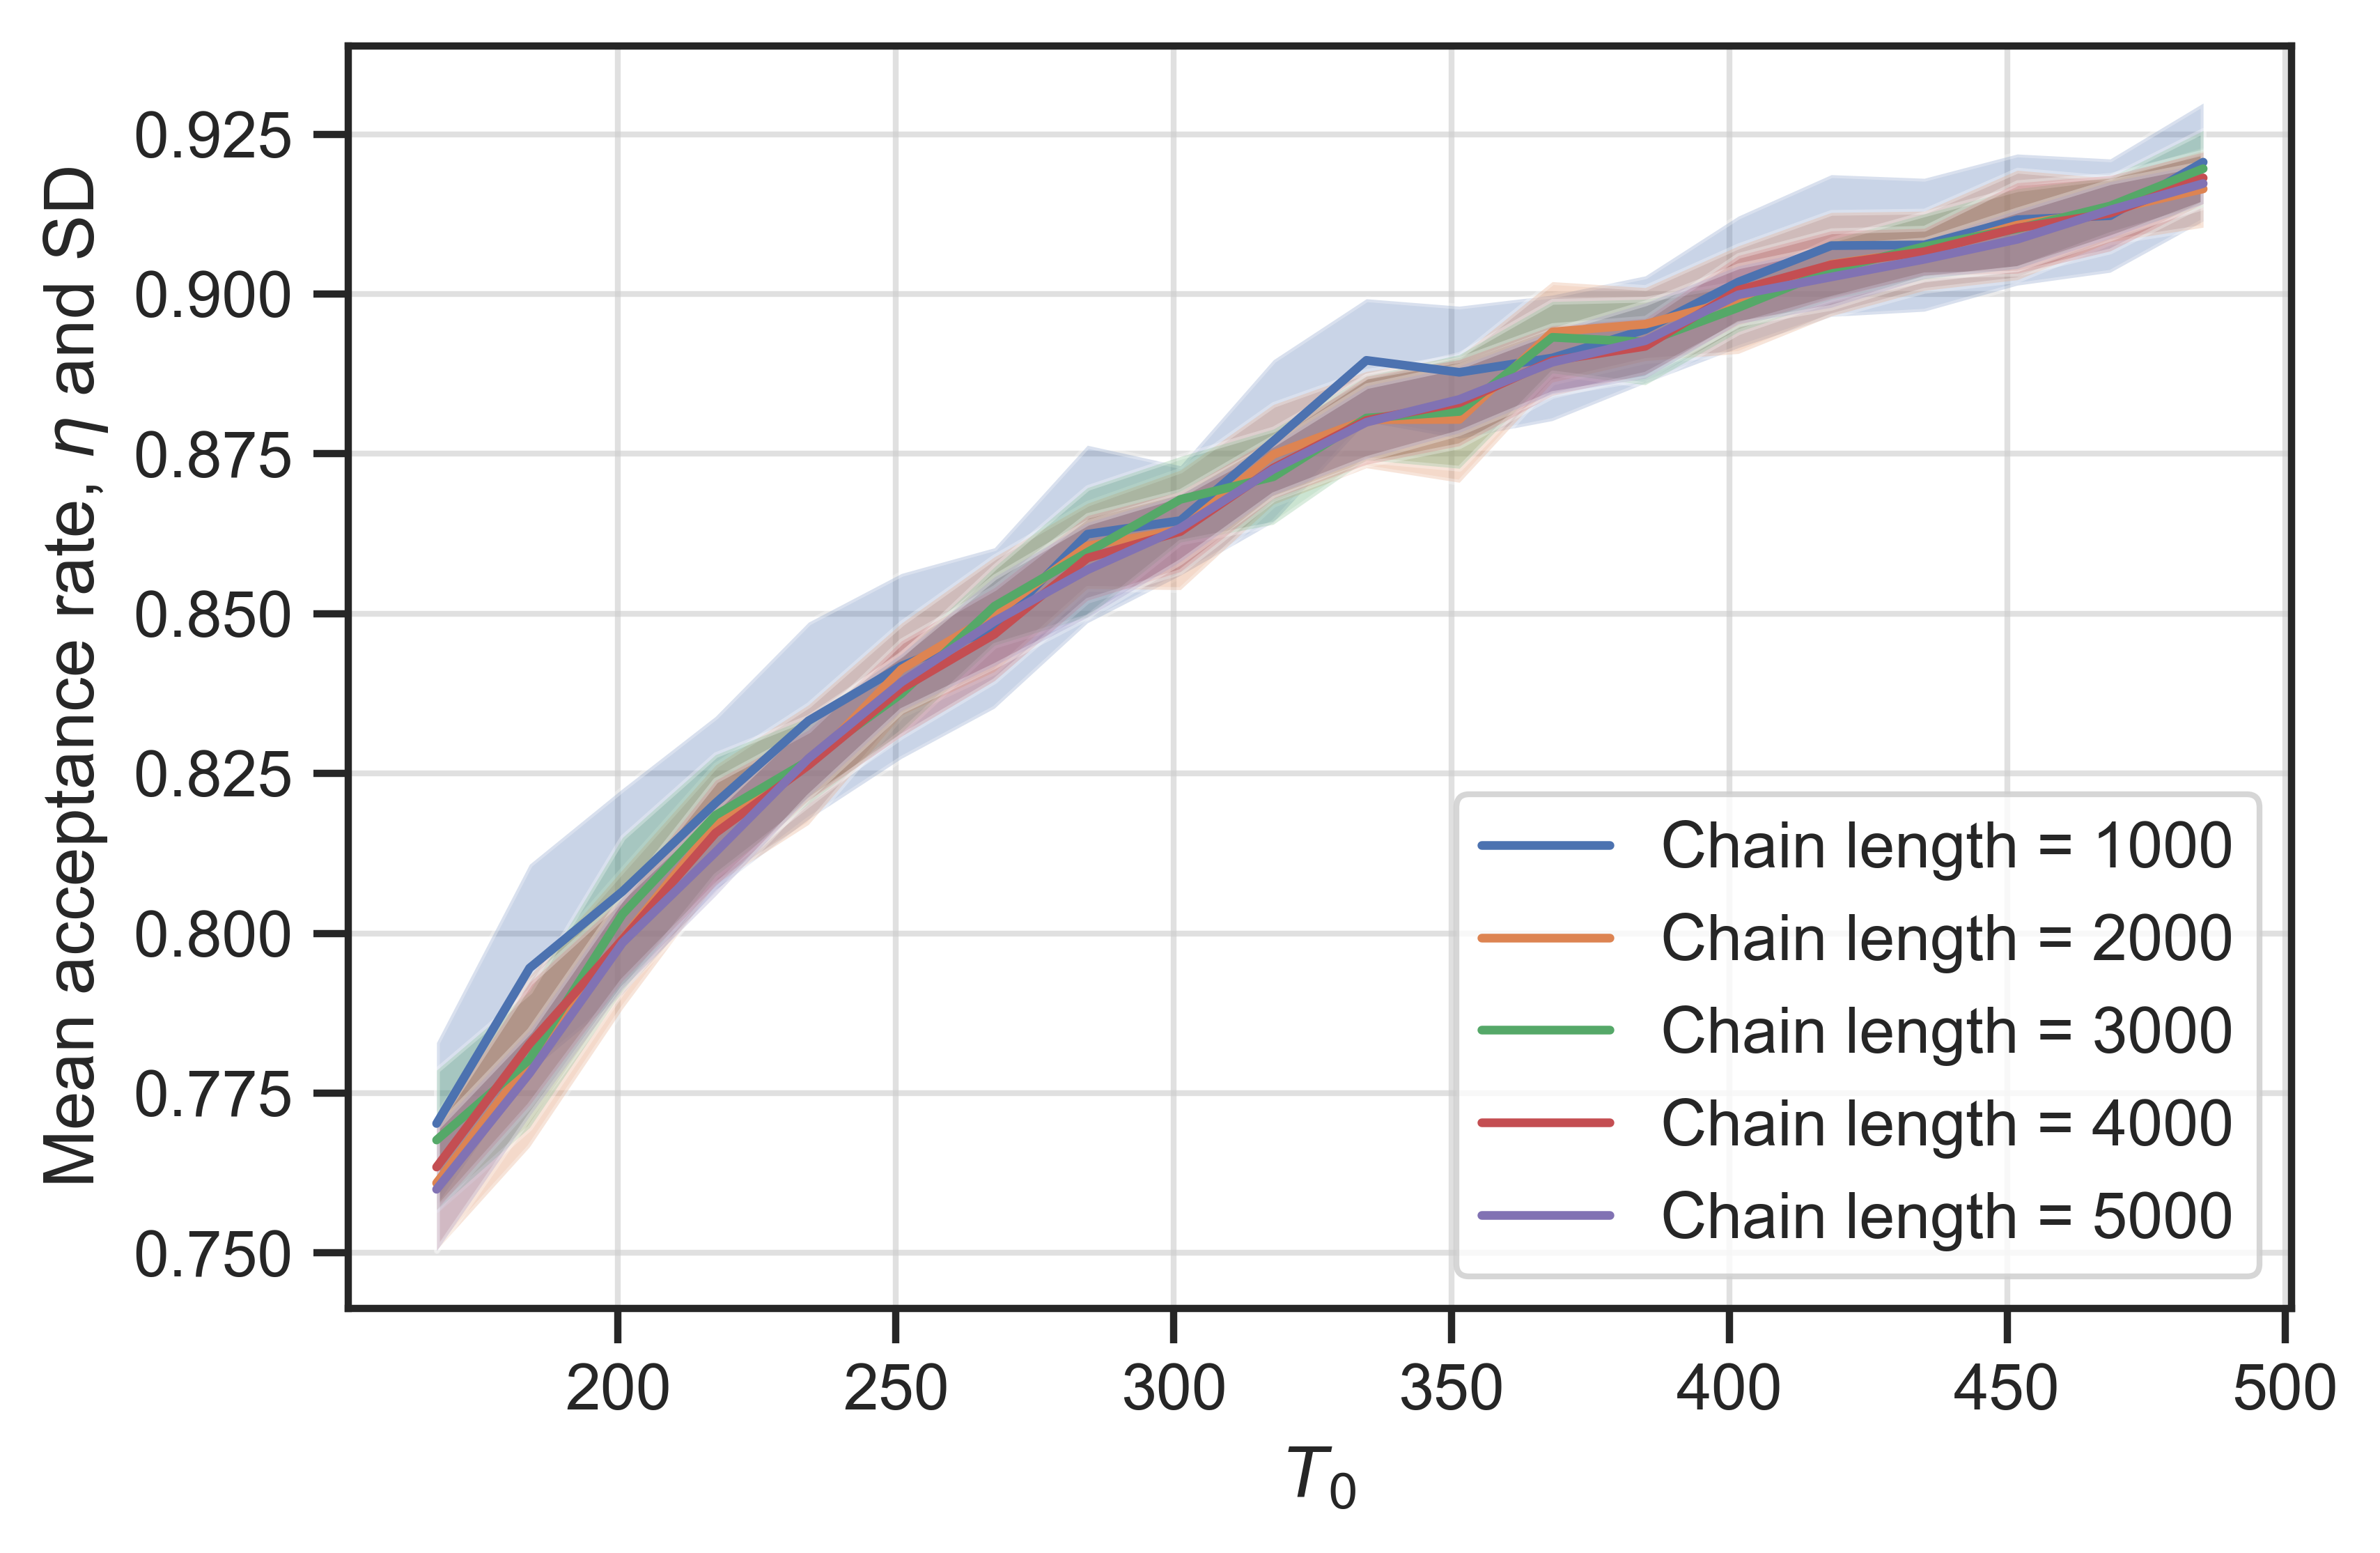

In [182]:
multiple_lines_plotter(simulated_data = "a280_proto_param_sweep.npz", title = "Many_lines_acc_rates.pdf")

In [183]:
def two_lines_plotter(simulated_data, title):
    
    """
    Plots mean acceptance rate and SD given the corresponting initial temperature 
    for two different Markoc chain lenghts.
    
    """

    cost_func, dcost_func = COST_FUNCTION_PAIRS[1]
    node_count = first(cost_func.D.shape)
    
    root_N = np.sqrt(node_count)
    _start_c_value = 10
    _end_c_value = 30
    c_values = np.arange(_start_c_value, _end_c_value, dtype = f64)
    T0_values = c_values * root_N
    
    chain_lengths = np.linspace(1000, 5000, 5, dtype = np.int32)
    filename = simulated_data
    filepath = save_path_2(filename)
    
    acceptance_rates = np.load(filepath)['arr_0']
    
    plt.xlabel("$T_0$", size = 13)
    plt.ylabel("Mean acceptance rate, $\eta$ and SD", size = 13)
    
    ind = 0
    acc_rates_1000 = acceptance_rates[ind]
    mean_acc_rates_1000 = np.mean(acc_rates_1000, axis = 1)
    std_acc_rates_1000 = np.std(acc_rates_1000, axis = 1)
    plt.plot(T0_values, mean_acc_rates_1000, label = f"Chain length = {chain_lengths[ind]}")
    plt.fill_between(T0_values, mean_acc_rates_1000 - std_acc_rates_1000, mean_acc_rates_1000 + std_acc_rates_1000, alpha = 0.3)

    
    ind = -2
    acc_rates_4000 = acceptance_rates[ind]
    mean_acc_rates_4000 = np.mean(acc_rates_4000, axis = 1)
    std_acc_rates_4000 = np.std(acc_rates_4000, axis = 1)
    plt.plot(T0_values, mean_acc_rates_4000, label = f"Chain length = {chain_lengths[ind]}")
    plt.fill_between(T0_values, mean_acc_rates_4000 - std_acc_rates_4000, mean_acc_rates_4000 + std_acc_rates_4000, alpha = 0.3)
    
    plt.grid(alpha = 0.6)
    plt.legend()
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()

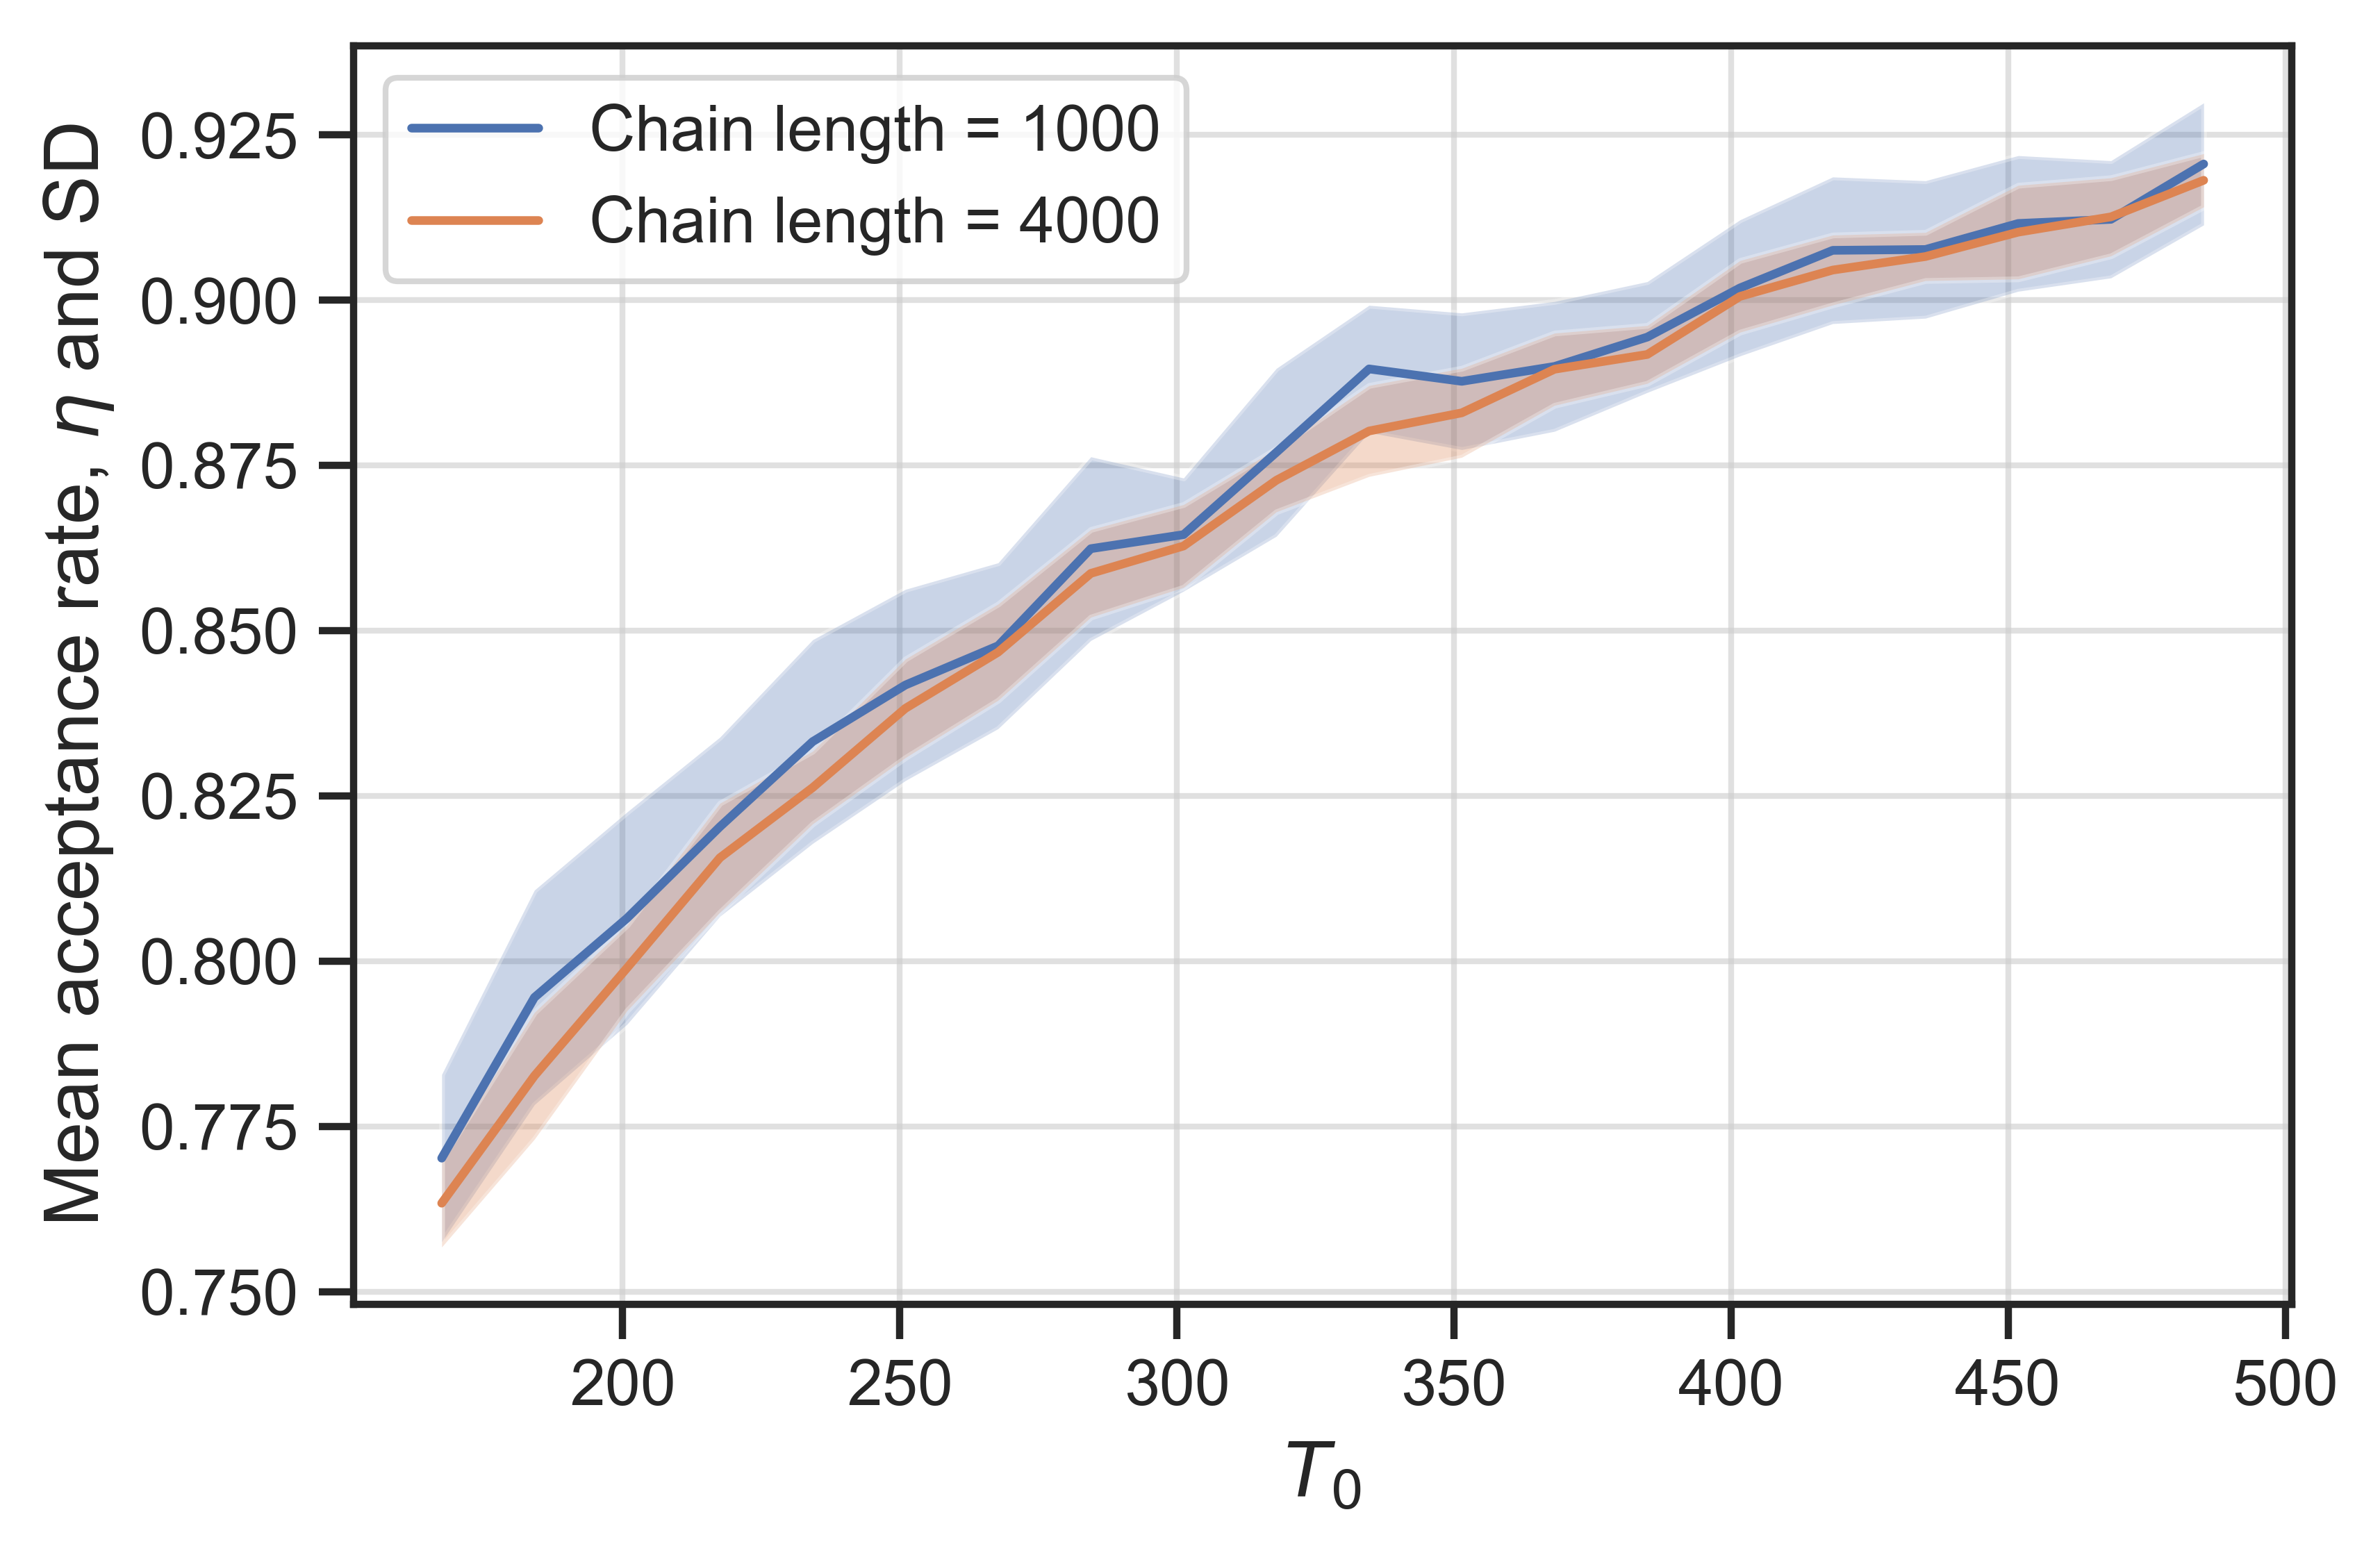

In [184]:
two_lines_plotter(simulated_data = "a280_proto_param_sweep.npz", title = "Two_lines_acc_rates.pdf")

## Visualization of Cooling Schedules

In [92]:
def geometric_steps_c(T0, Tf, steps):
    """
    TODO:
    
    """
    assert Tf < T0
    assert Tf > 0
    assert steps > 0
    return np.exp(np.log(Tf/T0)/steps)

def linear_steps_c(T0, Tf, steps):
    """
    TODO:
    
    """
    assert Tf < T0
    assert Tf > 0
    assert steps > 0
    return (T0 - Tf)/steps

def log_steps_c(T0, Tf, steps):
    """
    TODO:
    
    """
    assert Tf < T0
    assert Tf > 0
    assert steps > 0
    return (T0/Tf - 1.0)/(np.log(1+steps))

def exp_steps_c(T0, Tf, steps):
    """
    TODO:
    
    """
    assert Tf < T0
    assert Tf > 0
    assert steps > 0
    return -np.log((Tf/T0))/steps

In [185]:
def plot_cooling_schedules(title):
    
    """
    TODO:
    
    """
    
    T0 = 1000
    Tf = 1.0

    steps = 1000

    args = (T0, Tf, steps)

    c_geometric = geometric_steps_c(*args)
    geometric_cooling = GeometricCoolingSchedule(c_geometric)


    c_linear = linear_steps_c(*args)
    linear_cooling = LinearCoolingSchedule(c_linear)


    log_cooling = LogarithmicCoolingSchedule(2.0)


    coolers = [linear_cooling, geometric_cooling]# , log_cooling]
    labels = ["Linear", "Geometric", "Log"]
    cooling_timeseries = [[] for _ in coolers]

    for i,cooler in enumerate(coolers):
        T = T0
        j = 0
        #print(f"[INFO] Done with {i} of {len(coolers)} cooling schedules")
        while (T > Tf):
            cooling_timeseries[i].append(T)
            T = cooler(T0, j)
            j += 1

    # doing log separately because trying to get the same final temperature results in OF (in float64)
    cooling_timeseries.append([])
    T = T0
    for i in range(1,1003):
        cooling_timeseries[-1].append(T)
        T = log_cooling(T0, i)

    for i,Ts in enumerate(cooling_timeseries):
        plt.plot(range(len(Ts)), Ts, label = labels[i])
    plt.legend()

    plt.grid(True)
    plt.ylabel("Steps")
    plt.xlabel("Steps")
    
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')

    plt.show()

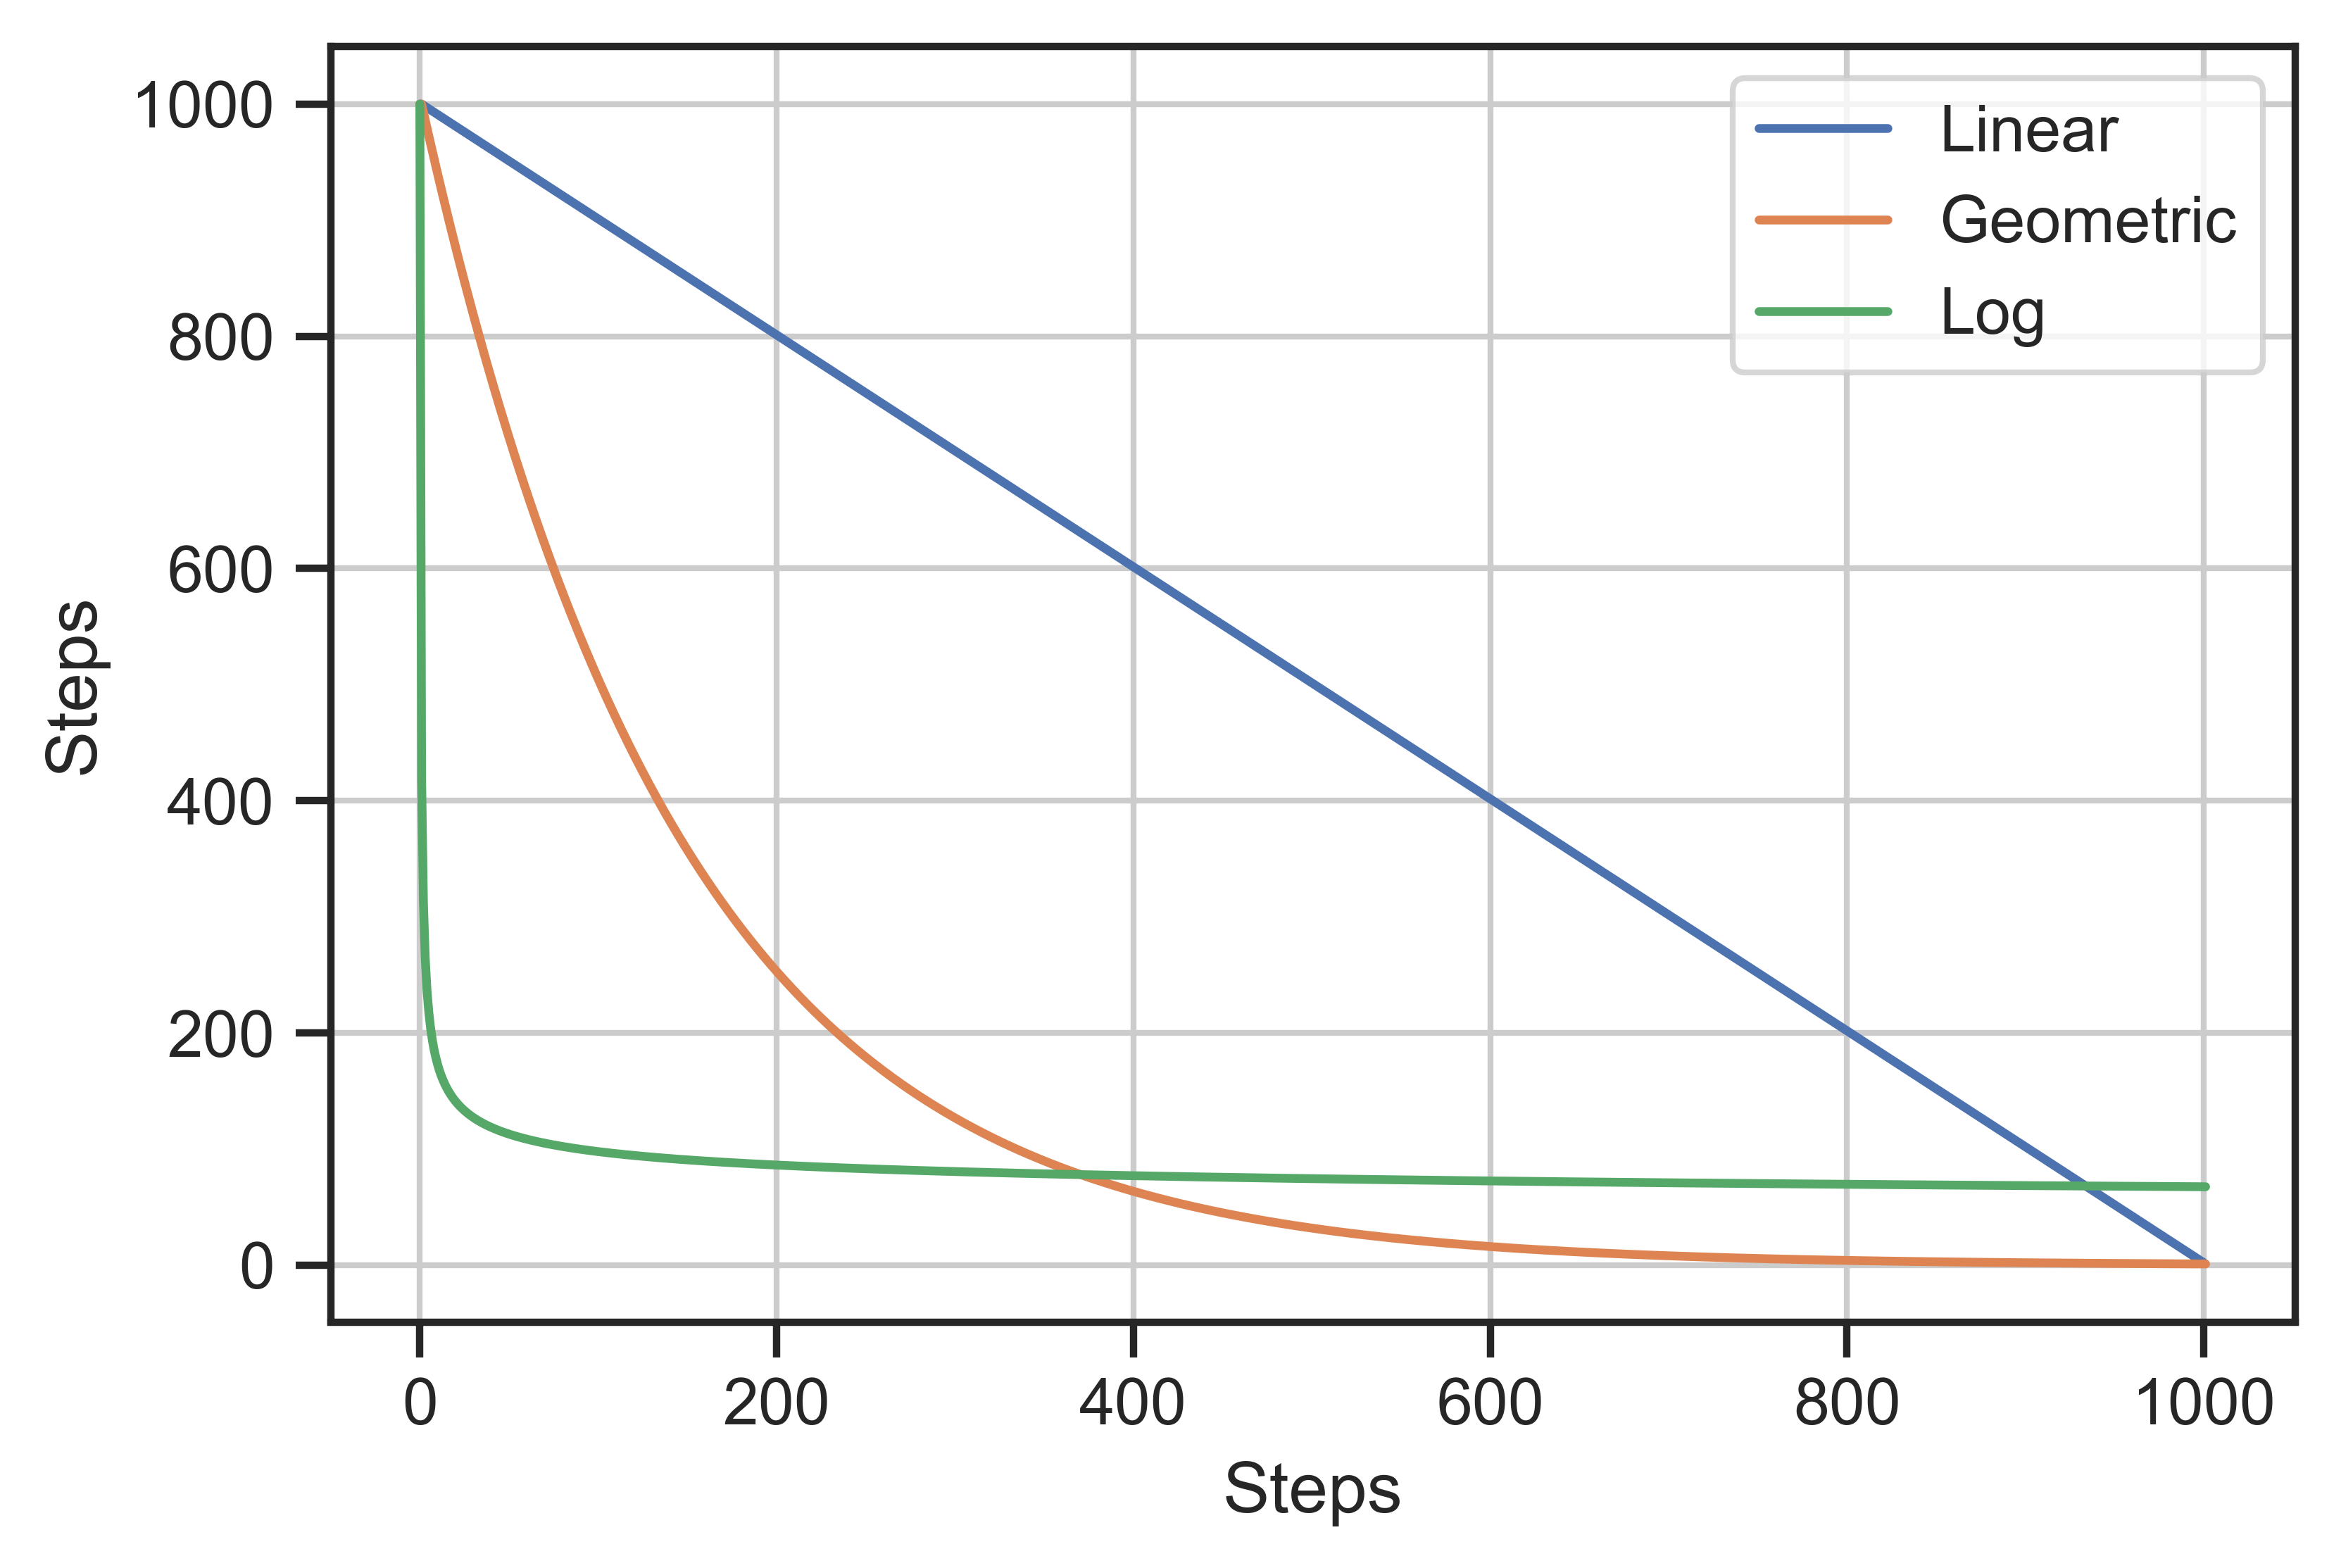

In [186]:
plot_cooling_schedules(title = "Three_schedules.pdf")

## Convergence Properties by Parameter Values for `a280.tsp`

### Linear Cooling

In [170]:
"""
Simulation 1: linear cooling schedule with varying parameter values, initial temperature of 400,
Markov chain length of 1000 and varying chain counts of TODO: stopping condition?, 20 runs.

Saves list of min costs and initial acceptance rate and writes a data file. 
If the file exists, loads it.

"""

T0 = 400.
Tf = 0.1
chain_length = 1000

stopping = StoppingCriterion.MIN_TEMPERATURE
T_final = Tf
cost_probing = CostProbing.ACCEPTED

chain_counts = np.linspace(100., 500., 11)
linear_param_values = np.array([linear_steps_c(T0, Tf, k) for k in chain_counts])

Ni = len(linear_param_values)
batch_size = 20

npz_filename = "linear_param_sweep_a280_2.npz"
npz_filepath = save_path_2(npz_filename)

rngs = generate_rngs(Ni)

args = (cost_func, stopping, cost_probing, T_final)
min_costs_list = np.full((Ni, batch_size), f64('nan'))
acceptance_rates_list = np.full((Ni, batch_size), f64('nan'))
print(f"T0 = {T0}, Tf = {Tf}")

if not exists(npz_filepath):
    print("[INFO] performing parameter sweep")
    for i,p in enumerate(linear_param_values):
        print(f"[INFO] done with {i} of {Ni} batches")
        cooling = LinearCoolingSchedule(p)
        system = SAMinimizer(transition, dcost_func, cooling, rngs[i].uniform, state_constructor)
        #def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
        min_costs, acceptance_rates = run_batch(system, batch_size, chain_length, T0, *args)
        acceptance_rates_list[i] = acceptance_rates
        min_costs_list[i] = min_costs
    print("[INFO] done with all batches")
    np.savez(npz_filepath, min_costs_list, acceptance_rates_list)
else:
    with np.load(npz_filepath) as save_data:
        min_costs_list = save_data['arr_0']
        acceptance_rates_list = save_data['arr_1']
        
mean_min_costs = np.mean(min_costs_list, axis = 1)
std_min_costs = np.std(min_costs_list, axis = 1)

mean_acc_rates = np.mean(acceptance_rates_list, axis = 1)
std_acc_rates = np.std(acceptance_rates_list, axis = 1)

T0 = 400.0, Tf = 0.1


In [187]:
def linear_cooling_alpha_plotter(simulated_data, to_plot, title):
    
    """ 
    Plots average cost and SD for varying linear cooling parameters when to_plot == 'mean_cost'.
    
    Plots mean initial acceptance rates and SD for varying linear cooling parameters 
    when to_plot == 'mean_acc_rates'.
    
    """
    
    T0 = 1000.
    Tf = 1.
    chain_counts = np.linspace(100., 500., 11)
    linear_param_values = np.array([linear_steps_c(T0, Tf, k) for k in chain_counts])
    
    filename = simulated_data
    filepath = save_path_2(filename)
    
    min_costs_list = np.load(filepath)['arr_0']
    mean_min_costs = np.mean(min_costs_list, axis = 1)
    std_min_costs = np.std(min_costs_list, axis = 1)
    
    acceptance_rates_list = np.load(filepath)['arr_1']
    mean_acc_rates = np.mean(acceptance_rates_list, axis = 1)
    std_acc_rates = np.std(acceptance_rates_list, axis = 1)
    
    if to_plot=="mean_cost":
        plt.errorbar(linear_param_values, mean_min_costs, yerr=std_min_costs, linestyle="dashed", linewidth = 1, marker='o', capsize=3, markersize="4", mfc='darkblue', color='steelblue', label = "Average optimum cost and SD")
        plt.fill_between(linear_param_values, mean_min_costs-std_min_costs, mean_min_costs+std_min_costs, alpha=.25, color="steelblue")
        plt.ylabel("Cost", size = 14) 
    if to_plot=="mean_acc_rates":
        plt.errorbar(linear_param_values, mean_acc_rates, yerr=std_acc_rates, linestyle="dashed", linewidth = 1, marker='o', capsize=3, markersize="4", mfc='darkseagreen', color='seagreen', label = "Average initial acceptance and SD")
        plt.fill_between(linear_param_values, mean_acc_rates-std_acc_rates, mean_acc_rates+std_acc_rates, alpha=.25, color="seagreen")
        plt.ylabel("Acceptance rate", size = 14) 
        plt.ylim(0.945, 0.975)

    plt.xlabel("Linear cooling parameter, $\\delta$", size = 14) 
    plt.legend(fontsize = 'large')
    plt.grid(alpha = 0.6)
    
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()

(11, 20)


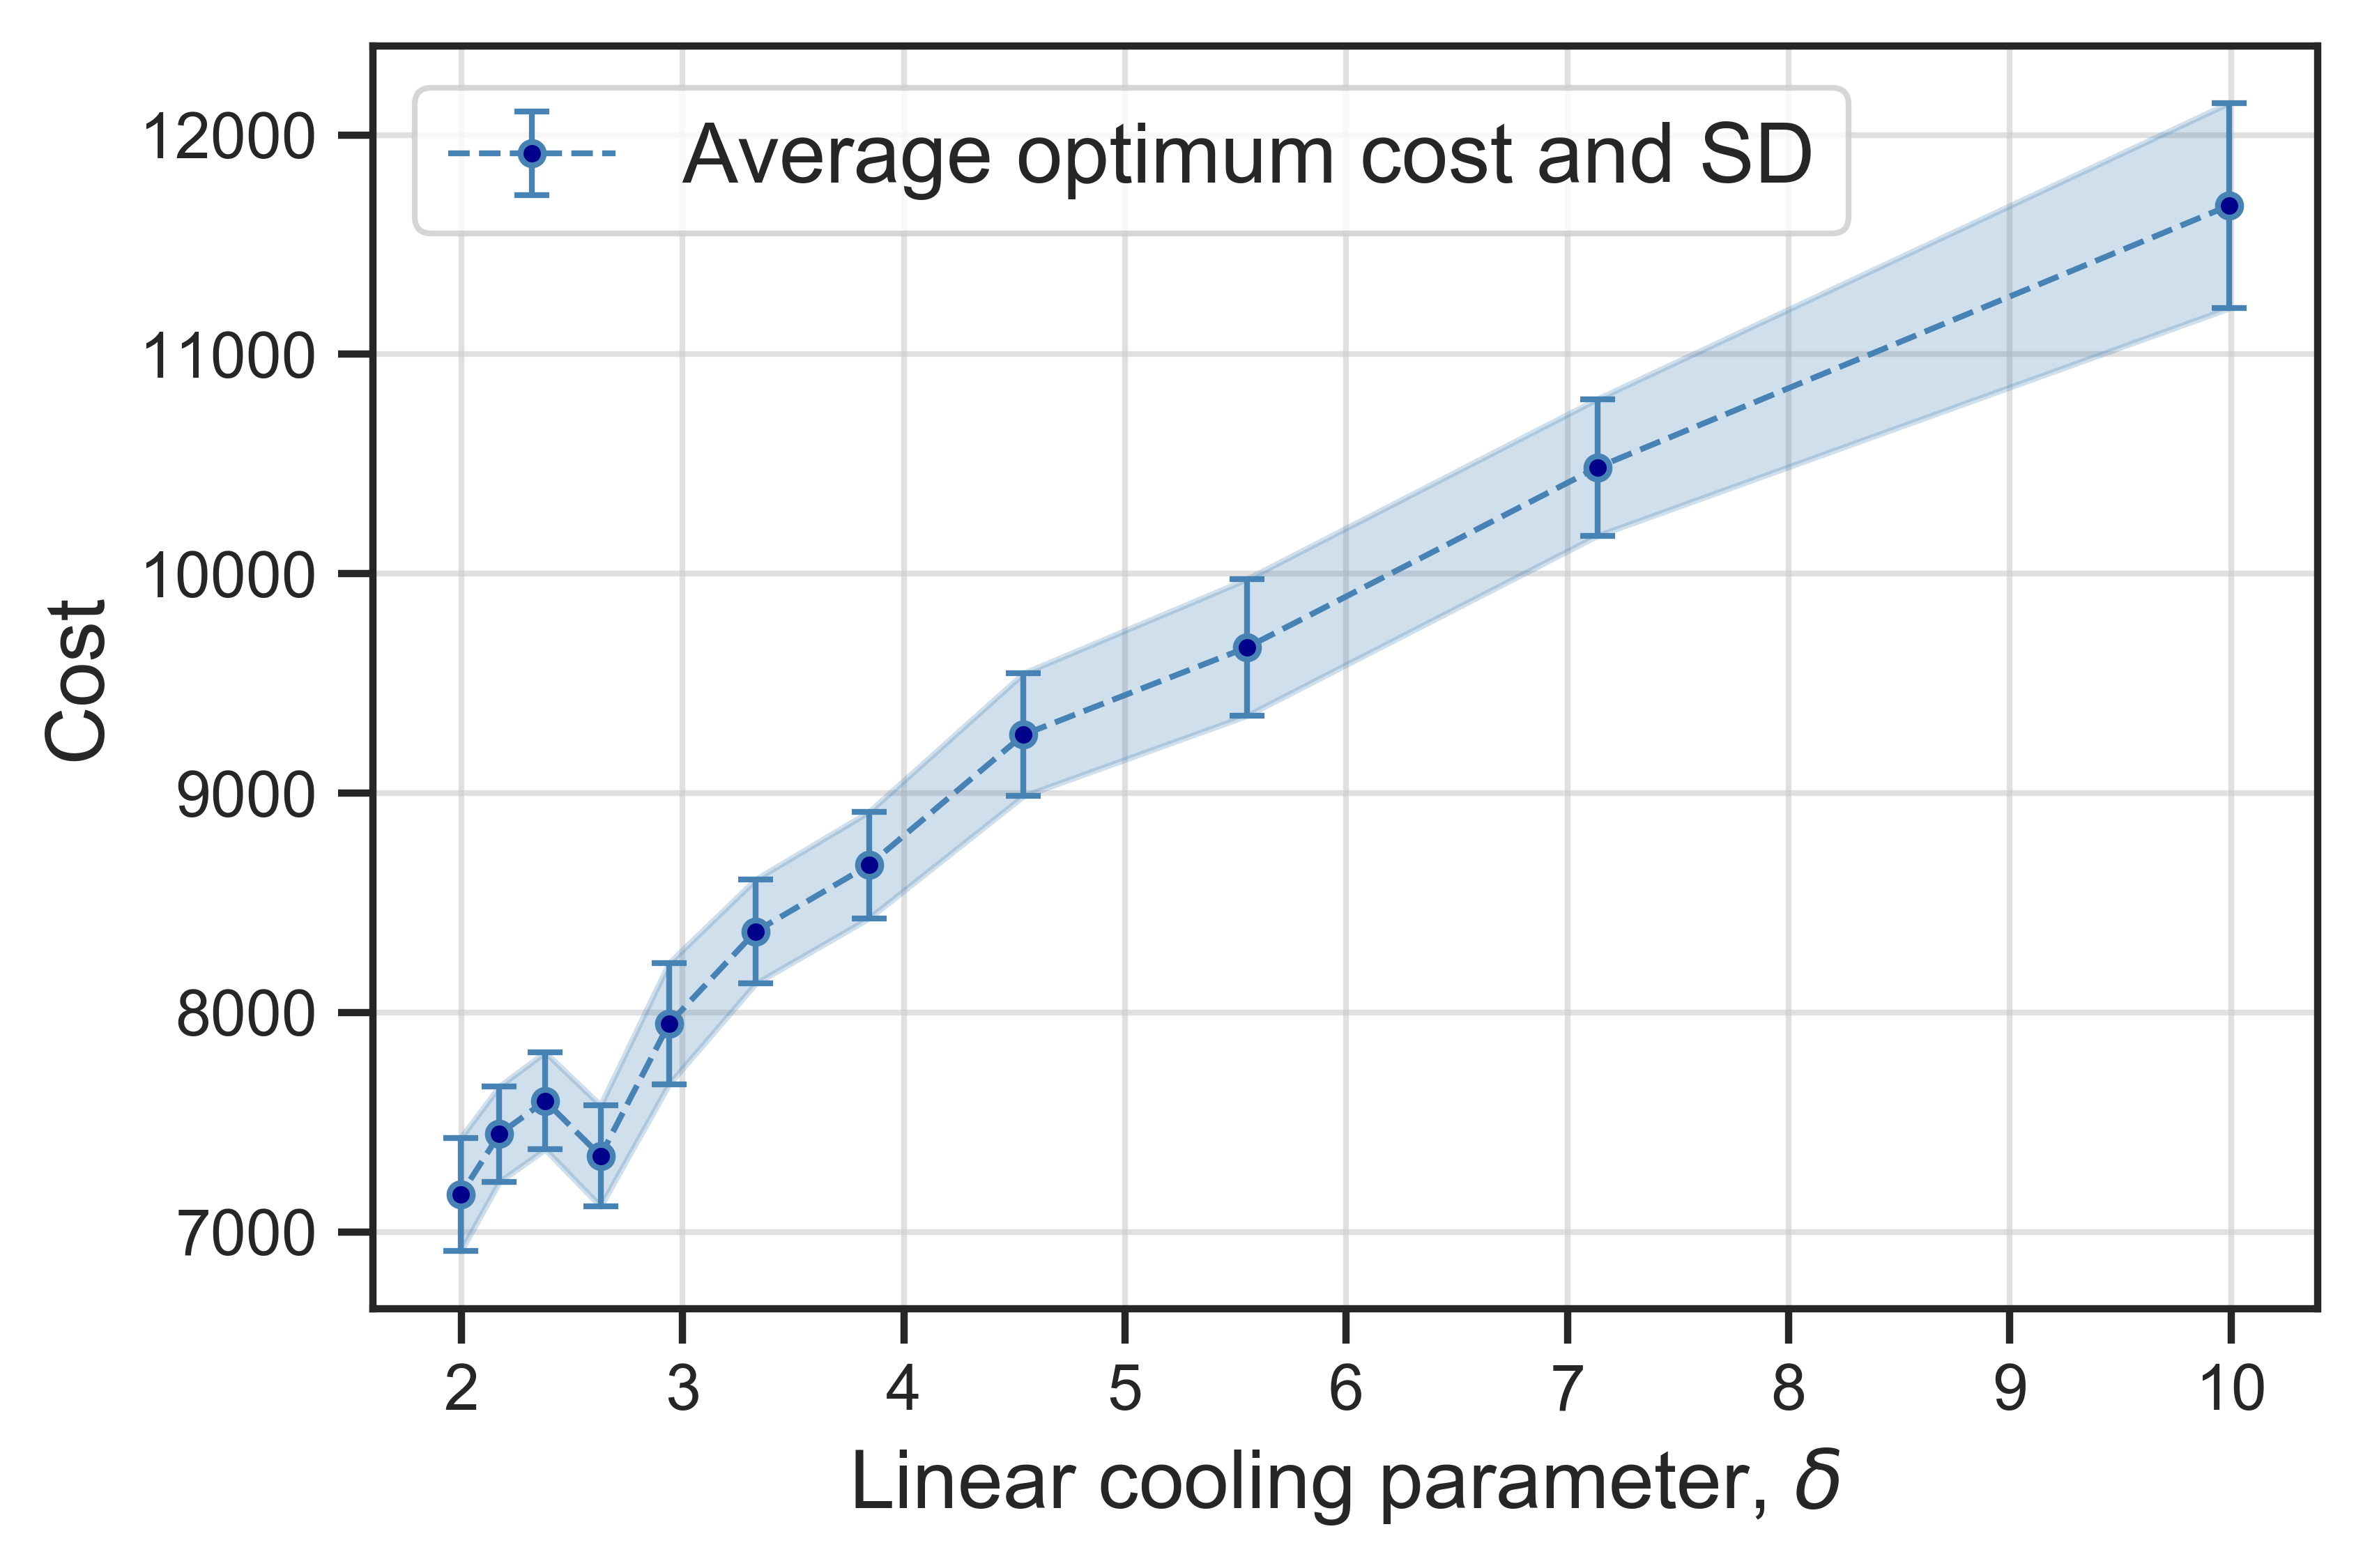

In [188]:
linear_cooling_alpha_plotter(simulated_data = "linear_param_sweep_a280.npz", to_plot="mean_cost", title = "Linear_cooling.pdf")
#linear_cooling_alpha_plotter(simulated_data = "linear_param_sweep_a280.npz", to_plot="mean_acc_rates", title = "Linear_cooling_acc_rates.pdf")

### Geometric Cooling

In [189]:
"""
Simulation 2: geometric cooling schedule with varying parameter values, initial temperature of 400,
Markov chain length of 1000 and varying chain counts of TODO: stopping condition?, 20 runs.

Saves list of min costs and initial acceptance rate and writes a data file. 
If the file exists, loads it.

"""

T0 = 400.
Tf = 0.1
chain_length = 1000

stopping = StoppingCriterion.MIN_TEMPERATURE
T_final = Tf
cost_probing = CostProbing.ACCEPTED

geometric_param_values = np.array([geometric_steps_c(T0, Tf, k) for k in chain_counts])
Ni = len(geometric_param_values)

batch_size = 20

npz_filename = "geometric_sweep_a280_2.npz"
npz_filepath = save_path_2(npz_filename)

rngs = generate_rngs(Ni)

args = (cost_func, stopping, cost_probing, T_final)
min_costs_list = np.full((Ni, batch_size), f64('nan'))
acceptance_rates_list = np.full((Ni, batch_size), f64('nan'))
print(f"T0 = {T0}, Tf = {Tf}")

if not exists(npz_filepath):
    print("[INFO] performing parameter sweep")
    for i,p in enumerate(geometric_param_values):
        print(f"[INFO] done with {i} of {Ni} batches")
        cooling = GeometricCoolingSchedule(p)
        system = SAMinimizer(transition, dcost_func, cooling, rngs[i].uniform, state_constructor)
        #def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
        min_costs, acceptance_rates = run_batch(system, batch_size, chain_length, T0, *args)
        acceptance_rates_list[i] = acceptance_rates
        min_costs_list[i] = min_costs
    print("[INFO] done with all batches")
    np.savez(npz_filepath, min_costs_list, acceptance_rates_list)
else:
    with np.load(npz_filepath) as save_data:
        min_costs_list = save_data['arr_0']
        acceptance_rates_list = save_data['arr_1']
        
        
mean_min_costs = np.mean(min_costs_list, axis = 1)
std_min_costs = np.std(min_costs_list, axis = 1)

mean_acc_rates = np.mean(acceptance_rates_list, axis = 1)
std_acc_rates = np.std(acceptance_rates_list, axis = 1)


T0 = 400.0, Tf = 0.1


In [192]:
def geometric_cooling_param_plotter(simulated_data, to_plot, title):

    """ 
    Plots average cost and SD for varying geometric cooling parameters when to_plot == 'mean_cost'.
    
    Plots mean initial acceptance rates and SD for varying geometric cooling parameters 
    when to_plot == 'mean_acc_rates'.
    
    """
    
    
    T0 = 1000.
    Tf = 1.
    chain_counts = np.linspace(100., 500., 11)
    geometric_param_values = np.array([geometric_steps_c(T0, Tf, k) for k in chain_counts])
    
    filename = simulated_data
    filepath = save_path_2(filename)

    min_costs_list = np.load(filepath)['arr_0']
    mean_min_costs = np.mean(min_costs_list, axis = 1)
    std_min_costs = np.std(min_costs_list, axis = 1)
    
    acceptance_rates_list = np.load(filepath)['arr_1']
    mean_acc_rates = np.mean(acceptance_rates_list, axis = 1)
    std_acc_rates = np.std(acceptance_rates_list, axis = 1)
    
    if to_plot=="mean_cost":
        plt.errorbar(geometric_param_values, mean_min_costs, yerr=std_min_costs, linestyle="dashed", linewidth = 1, marker='o', capsize=3, markersize="4", mfc='darkblue', color='steelblue', label = "Average optimum cost and SD")
        plt.fill_between(geometric_param_values, mean_min_costs-std_min_costs, mean_min_costs+std_min_costs, alpha=.25, color="steelblue")
        plt.ylabel("Cost", size = 14) 
    if to_plot=="mean_acc_rates":
        plt.errorbar(geometric_param_values, mean_acc_rates, yerr=std_acc_rates, linestyle="dashed", linewidth = 1, marker='o', capsize=3, markersize="4", mfc='darkseagreen', color='seagreen', label = "Average initial acceptance and SD")
        plt.fill_between(geometric_param_values, mean_acc_rates-std_acc_rates, mean_acc_rates+std_acc_rates, alpha=.25, color="seagreen")
        plt.ylabel("Acceptance rate", size = 14) 
        plt.ylim(0.945, 0.975)
    plt.xlabel("Geometric cooling parameter, $c_r$", size = 14)
    plt.legend(fontsize = 'large')
    plt.grid(alpha = 0.6)
    
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()

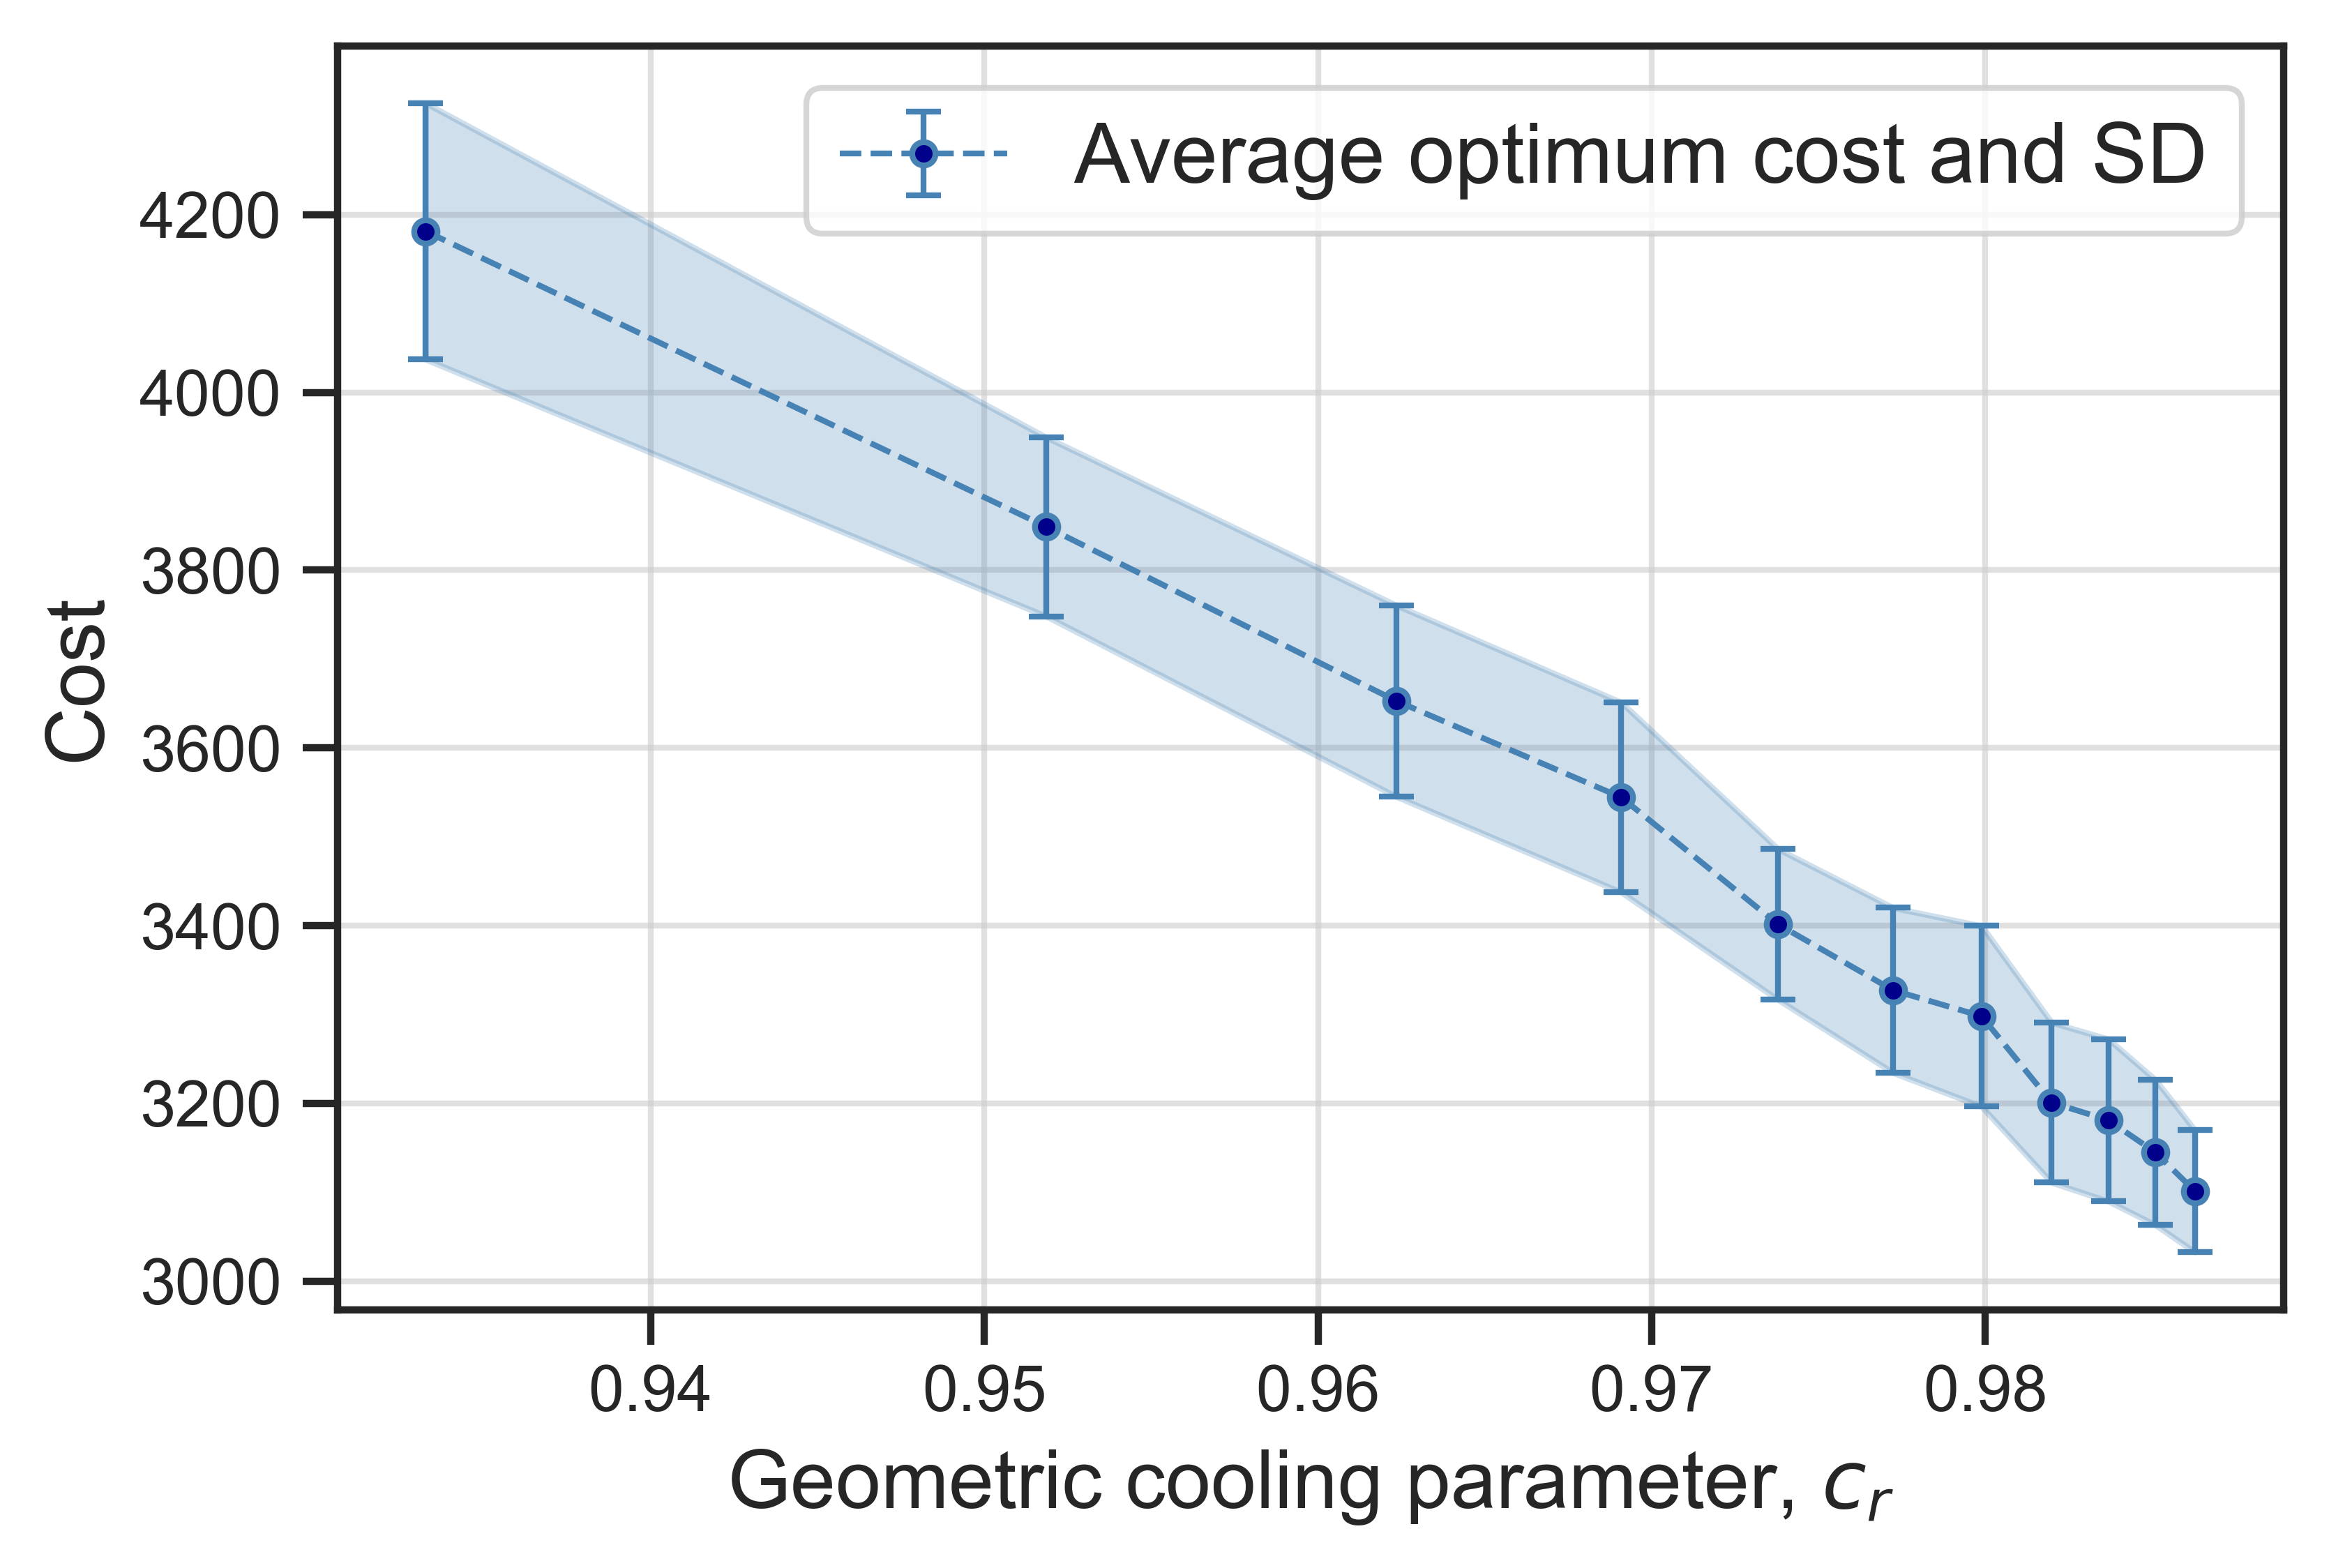

In [193]:
geometric_cooling_param_plotter(simulated_data = "geometric_sweep_a280.npz", to_plot="mean_cost",  title = "Geometric_param.pdf")
#geometric_cooling_param_plotter(simulated_data = "geometric_sweep_a280.npz", to_plot="mean_acc_rates",  title = "Geometric_acc_rates.pdf")

### Logarithmic Cooling

In [174]:
"""
Simulation 3: logarithmic cooling schedule with varying parameter values, initial temperature of 1,
Markov chain length of 1000 and varying chain counts of TODO: stopping condition?, 20 runs.

Saves list of min costs and initial acceptance rate and writes a data file. 
If the file exists, loads it.

"""

T0 = 1
Tf = 0.1
chain_length = 1000

chain_counts = np.linspace(100, 500, 11, dtype = np.int32)
log_param_values = np.array([log_steps_c(T0, Tf, k) for k in chain_counts])
Ni = len(log_param_values)

T_final = Tf
stopping = StoppingCriterion.MIN_TEMPERATURE


npz_filename = "log_param_sweep_280_2.npz"
npz_filepath = save_path_2(npz_filename)

rngs = generate_rngs(Ni)

args = (cost_func, stopping, cost_probing, T_final)
min_costs_list = np.full((Ni, batch_size), f64('nan'))
acceptance_rates_list = np.full((Ni, batch_size), f64('nan'))
print(f"T0 = {T0}, Tf = {Tf}")

if not exists(npz_filepath):
    print("[INFO] performing parameter sweep")
    for i,p in enumerate(log_param_values):
        print(f"[INFO] done with {i} of {Ni} batches")
        cooling = LogarithmicCoolingSchedule(p)
        system = SAMinimizer(transition, dcost_func, cooling, rngs[i].uniform, state_constructor)
        #def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
        min_costs, acceptance_rates = run_batch(system, batch_size, chain_length, T0, *args)
        acceptance_rates_list[i] = acceptance_rates
        min_costs_list[i] = min_costs
    print("[INFO] done with all batches")
    np.savez(npz_filepath, min_costs_list, acceptance_rates_list)
else:
    with np.load(npz_filepath) as save_data:
        min_costs_list = save_data['arr_0']
        acceptance_rates_list = save_data['arr_1']
        
mean_min_costs = np.mean(min_costs_list, axis = 1)
std_min_costs = np.std(min_costs_list, axis = 1)

mean_acc_rates = np.mean(acceptance_rates_list, axis = 1)
std_acc_rates = np.std(acceptance_rates_list, axis = 1)


T0 = 1, Tf = 0.1


In [190]:
def log_cooling_plotter(simulated_data, to_plot, title):

    """ 
    Plots average cost and SD for varying logarithmic parameters when to_plot == 'mean_cost'.
    
    Plots mean initial acceptance rates and SD for varying logarithmic parameters 
    when to_plot == 'mean_acc_rates'.
    
    """
    
    T0 = 1
    Tf = 0.1

    chain_counts = np.linspace(100, 500, 11, dtype = np.int32)
    log_param_values = np.array([log_steps_c(T0, Tf, k) for k in chain_counts])
    
    filename = simulated_data
    filepath = save_path_2(filename)

    min_costs_list = np.load(filepath)['arr_0']
    mean_min_costs = np.mean(min_costs_list, axis = 1)
    std_min_costs = np.std(min_costs_list, axis = 1)
    
    acceptance_rates_list = np.load(filepath)['arr_1']
    mean_acc_rates = np.mean(acceptance_rates_list, axis = 1)
    std_acc_rates = np.std(acceptance_rates_list, axis = 1)
    
    if to_plot=="mean_cost":
        plt.errorbar(log_param_values, mean_min_costs, yerr=std_min_costs, linestyle="dashed", linewidth = 1, marker='o', capsize=3, markersize="4", mfc='darkblue', color='steelblue', label = "Average optimum cost and SD")
        plt.fill_between(log_param_values, mean_min_costs-std_min_costs, mean_min_costs+std_min_costs, alpha=.25, color="steelblue")
        plt.ylabel("Cost", size = 14) 
    if to_plot=="mean_acc_rates":
        plt.errorbar(log_param_values, mean_acc_rates, yerr=std_acc_rates, linestyle="dashed", linewidth = 1, marker='o', capsize=3, markersize="4", mfc='darkseagreen', color='seagreen', label = "Average initial acceptance and SD")
        plt.fill_between(log_param_values, mean_acc_rates-std_acc_rates, mean_acc_rates+std_acc_rates, alpha=.25, color="seagreen")
        plt.ylabel("Acceptance rate", size = 14)
        plt.ylim(0.32, 0.4)
    
    plt.xlabel("Logarithmic cooling parameter, $\\alpha$", size = 14)
    plt.legend(fontsize = 'large')
    plt.grid(alpha = 0.6)
    
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()
    

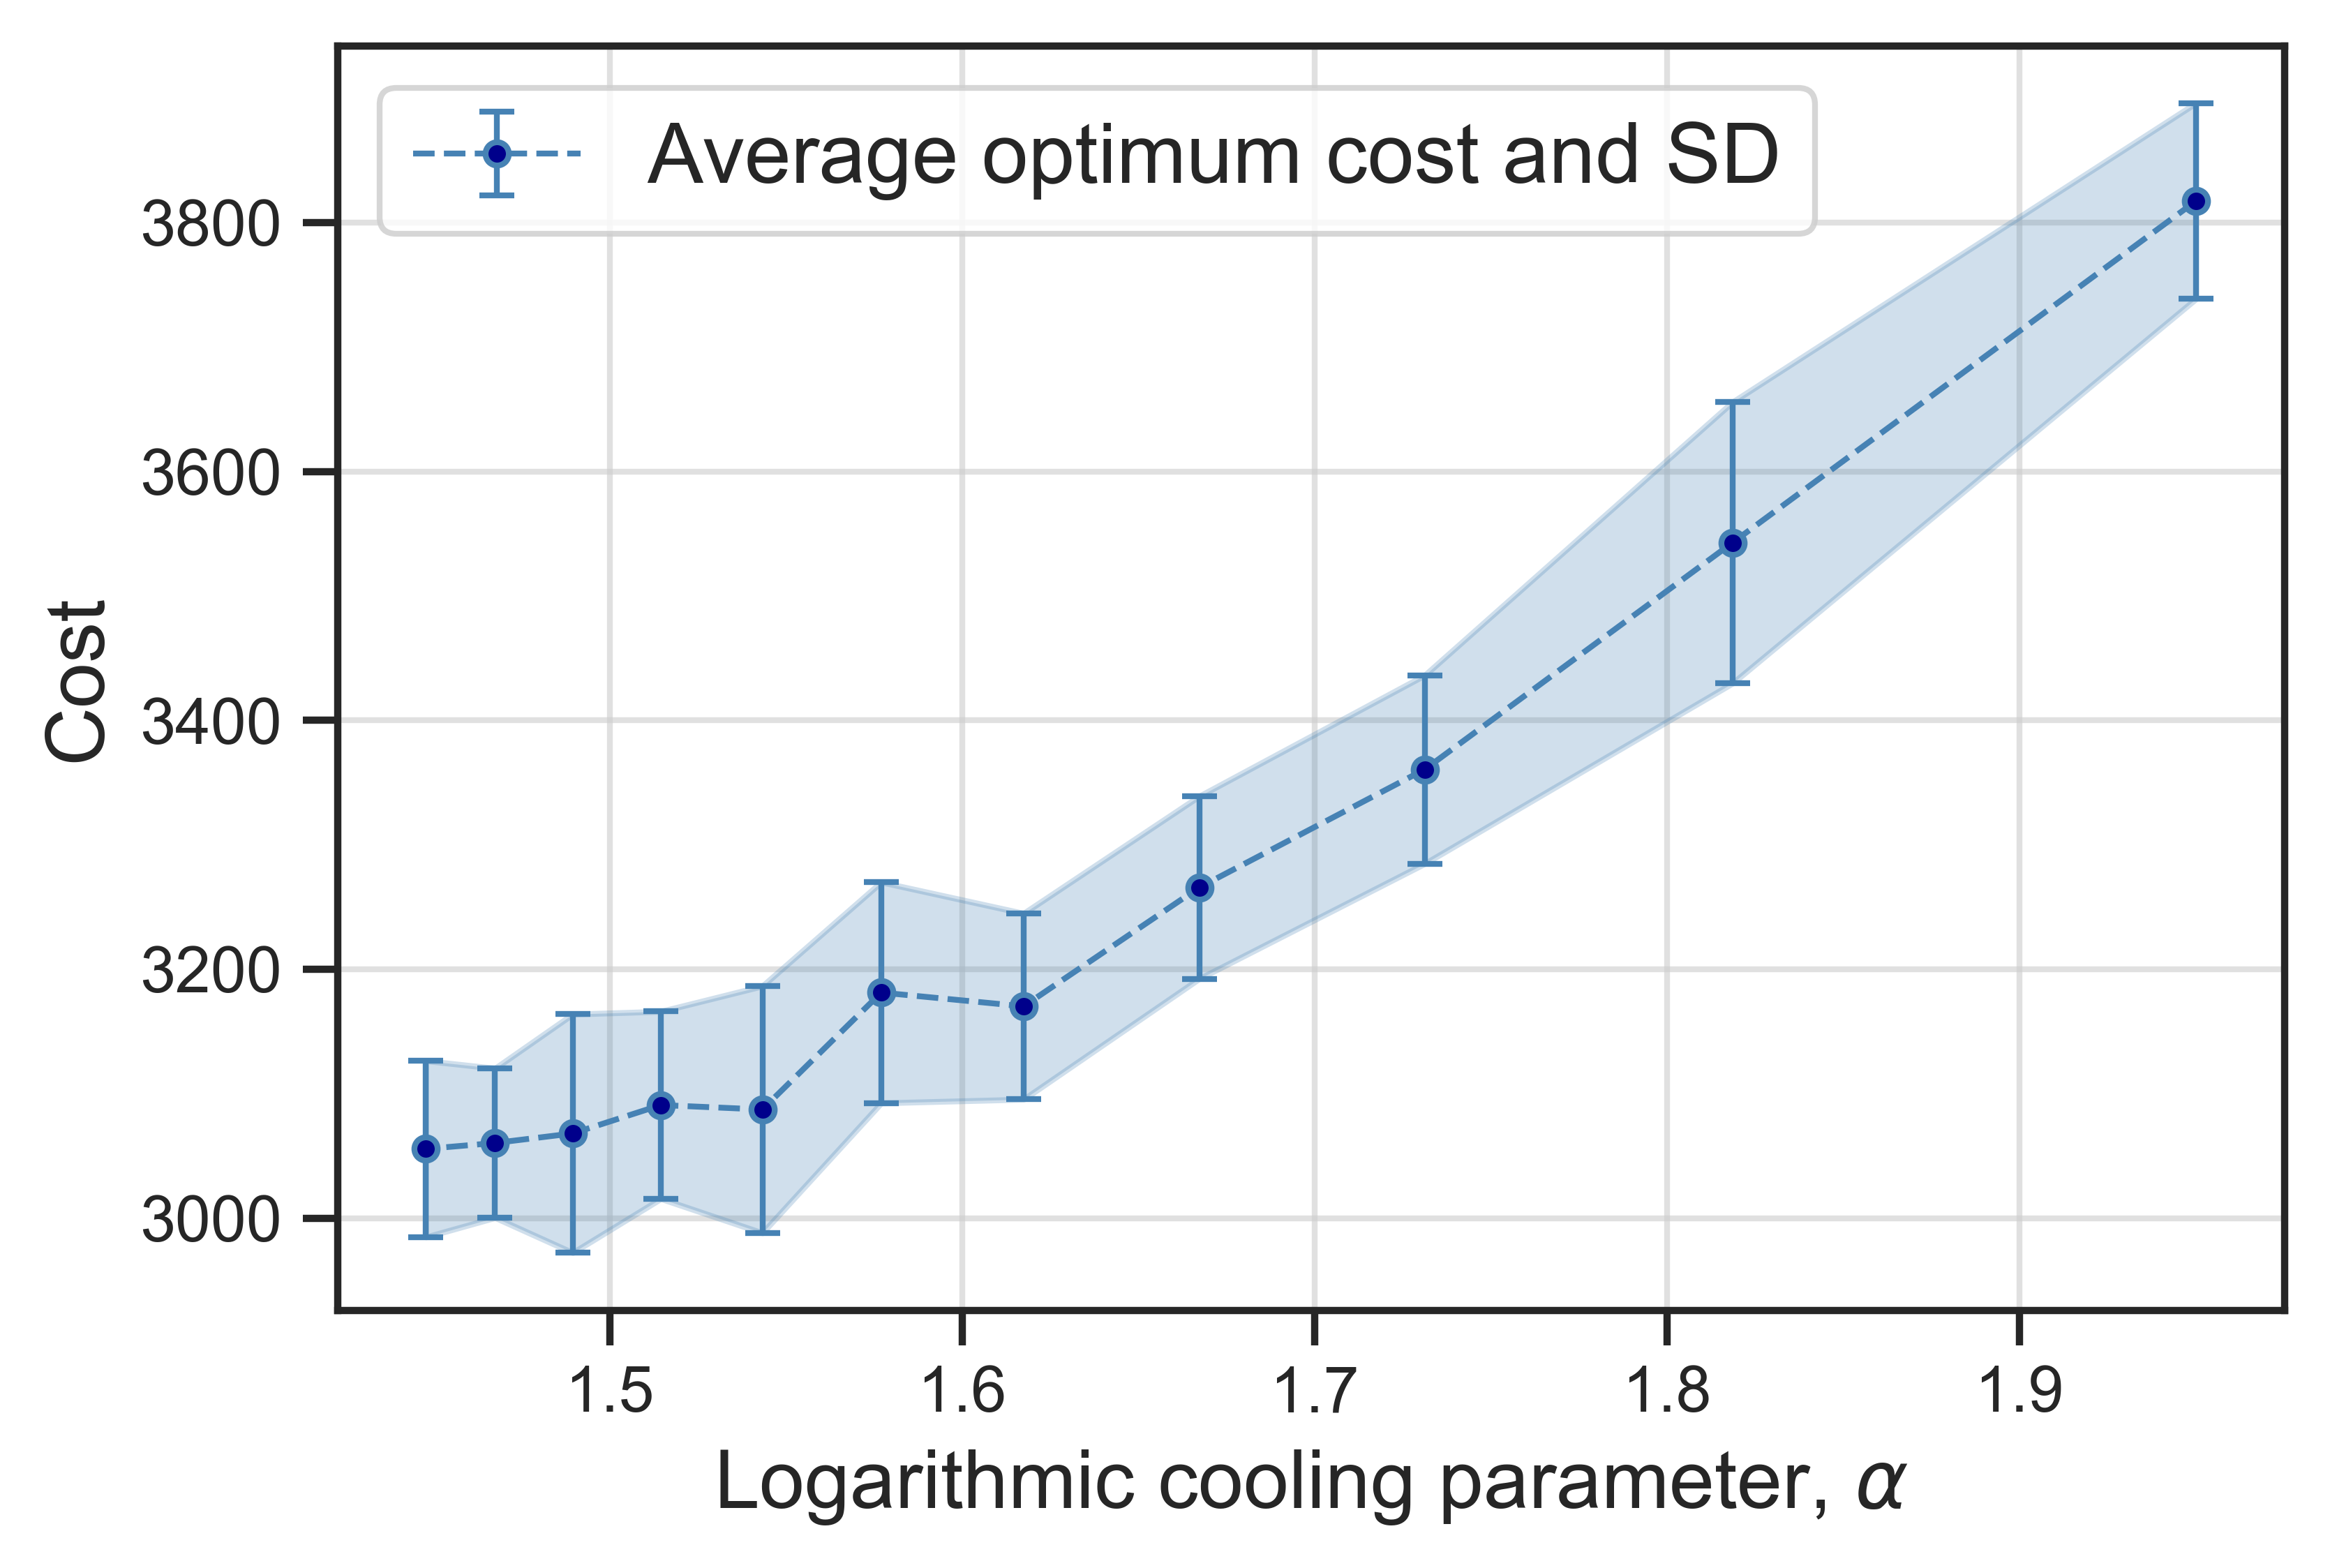

In [191]:
log_cooling_plotter(simulated_data = "log_param_sweep_280_2.npz", to_plot="mean_cost", title = "Log_param.pdf")
#log_cooling_plotter(simulated_data = "log_param_sweep_280_2.npz", to_plot="mean_acc_rates", title = "Log_param_acc_rates.pdf")

## Comparison of three cooling schemes
Box plots

In [194]:
"""
Simulation 4: three cooling schemes - linear (T0 = 400), geometric (T0 = 400), log (T0 = 0.1), 40 runs. TODO: parameter values?

Saves list of min costs for each cooling scheme and writes a data file. 
If the file exists, loads it.

"""

chain_count = 1000
chain_length = 500
T0 = 400.
Tf = 0.1

c_linear = linear_steps_c(T0, Tf, chain_count)
c_geometric = geometric_steps_c(T0, Tf, chain_count)
T0_log = 1
Tf_log = 0.1

c_logarithmic = log_steps_c(T0_log, Tf_log, chain_count)

parameters = [c_linear, c_geometric, c_logarithmic]
coolers_ctors = [LinearCoolingSchedule, GeometricCoolingSchedule, LogarithmicCoolingSchedule]
coolers = [coolers_ctors[i](p) for i,p in enumerate(parameters)]
linear_cooling, geometric_cooling, log_cooling = coolers

batch_size = 40

min_costs = np.full((len(coolers),batch_size), f64('nan'))
linear_rng, geometric_rng, log_rng = generate_rngs(3)  # order doesn't matter, but naming for readibility

# linear
# system = SAMinimizer(transition, dcost_func, cooling, rngs[i][j].uniform, state_constructor)

# system = SAMinimizer(transition, dcost_func, cooling, rngs[i][j].uniform, state_constructor)
linear_system = SAMinimizer(transition, dcost_func, linear_cooling, linear_rng.uniform, state_constructor)
geometric_system = SAMinimizer(transition, dcost_func, geometric_cooling, geometric_rng.uniform, state_constructor)
log_system = SAMinimizer(transition, dcost_func, log_cooling, log_rng.uniform, state_constructor)
systems = [linear_system, geometric_system, log_system]

# def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
args = (cost_func, stopping, cost_probing, Tf)
args_log = (cost_func, stopping, cost_probing, Tf_log)
npz_filename = "comparison_2.npz"
npz_filepath = save_path_2(npz_filename)
# objfile = "systems.bin"
# objpath = save_path_2(objfile)

if not exists(npz_filepath):
    min_costs[0], _ = run_batch(linear_system, batch_size, chain_length, T0, *args)
    min_costs[1], _ = run_batch(geometric_system, batch_size, chain_length, T0, *args)
    min_costs[2], _ = run_batch(log_system, batch_size, chain_length, T0_log, *args_log)
    np.savez(npz_filepath, min_costs)
else:
    with np.load(npz_filepath) as save_data:
        min_costs = save_data['arr_0']


In [195]:
def sample_mean_variance(counts):
    """Returns sample mean and sample variance of input array
    Parameters
    ----------
    counts: array of numbers
    
    Returns: 2-tuple (sample mean, sample variance)
    """
    n = len(counts)
    assert n > 1
    sample_mean = np.mean(counts)
    sample_variance = np.sum(np.power(counts - sample_mean, 2))/(n - 1)
    return (sample_mean, sample_variance)

def dashed_heading(text, length):
    
    """
    Pretty printing headings flanked by dashes.
    """
    
    dash_length = max(length - len(text), 0)
    ldash_length = dash_length // 2
    rdash_length = dash_length - ldash_length
    ldash = "-" * ldash_length
    rdash = "-" * rdash_length
    return ldash + text + rdash

def f_test(x, y):
    
    """
    Fisher's F-test for comparing sample variances of two distributions.
    Assumes both distributions are normal (or at least approximately normal)
    
    Returns
    -------
        f: float
            f-statistic, ratio of larger sample variance to the smaller one
        p: p-value
    """
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    
    return f, p

In [155]:
def three_cooling_boxplot(simulated_data, title):
    
    """
    Plots boxplot from simualation data 
    using seaborn's boxplot for three cooling schemes.
    
    Return F-test and corresponding T-test results
    
    """
    
    filename = simulated_data
    filepath = save_path_2(filename)

    min_costs = np.load(filepath)['arr_0']
    
    linear_mean, linear_var = sample_mean_variance(min_costs[0])
    geometric_mean, geometric_var = sample_mean_variance(min_costs[1])
    log_mean, log_var = sample_mean_variance(min_costs[2])
    
    
    p = 0.05
    n = 16 # number of simulations 
    linear_ci = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(linear_var)/np.sqrt(n)
    geom_ci = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(geometric_var)/np.sqrt(n)
    log_ci = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(log_var)/np.sqrt(n)

    print('Mean cost of linear schedule is', linear_mean, "±", linear_ci, "95% CI")
    print('Mean cost of geometric schedule is', geometric_mean, "±", geom_ci, "95% CI")
    print('Mean cost of logarithmic schedule is', log_mean, "±", log_ci, "95% CI")
    
    heading_length = 80
    
    def _heading(text):
        return dashed_heading(text, heading_length)

    print(_heading("Pair-wise F-tests"))

    corrected_p = 0.05 / 3 # bonferroni correction

    print("Corrected critical value (Bonferroni correction) is:", corrected_p)

    # 1. Linear vs Geometric:
    f1, p1 = f_test(min_costs[0], min_costs[1])

    if p1 < corrected_p:
        print(_heading("Linear vs Geometric"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of Linear cooling schedule equals to variance of Geometric cooling schedule")
        print("F-test statistic is:", f1, " and  p-value is:", p1)
        conclusion1 = "Null Hypothesis is rejected."

    else:
        print(_heading("Linear vs Geometric"))
        print(_heading("TEST STATISTICS"))
        print("H0:Variance of Linear cooling schedule equals to variance of Geometric cooling schedule")
        print("F-test statistic is:", f1, " and  p-value is:", p1)
        conclusion1 = "Failed to reject the null hypothesis."

    print(conclusion1)


    # 2.  Linear vs  Log:
    f2, p2 = f_test(min_costs[0], min_costs[2])

    if p2 < corrected_p:
        print(_heading("Linear vs  Log"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of Linear cooling schedule equals to variance of Log cooling schedule")
        print("F-test statistic is:", f2, " and  p-value is:", p2)
        conclusion2 = "Null Hypothesis is rejected."

    else:
        print(_heading("Linear vs  Log"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of Linear cooling schedule equals to variance of Log cooling schedule")
        print("F-test statistic is:", f2, " and  p-value is:", p2)
        conclusion2 = "Failed to reject the null hypothesis."

    print(conclusion2)

    # 3.  Geometric vs  Log:
    f3, p3 = f_test(min_costs[1], min_costs[2])

    if p3 < corrected_p:
        print(_heading("Geometric vs  Log"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of Geometric cooling schedule equals to variance of Log cooling schedule")
        print("F-test statistic is:", f3, " and  p-value is:", p3)
        conclusion3 = "Null Hypothesis is rejected."

    else:
        print(_heading("Geometric vs  Log"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of Geometric cooling schedule equals to variance of Log cooling schedule")
        print("F-test statistic is:", f3, " and  p-value is:", p3)
        conclusion3 = "Failed to reject the null hypothesis."

    print(conclusion3)


    if conclusion1 == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: Linear vs Geometric"))
        res1 = stats.ttest_ind(min_costs[0], min_costs[1], equal_var = False)
    else:
        print(_heading("T-test: Linear vs Geometric"))
        res1 = stats.ttest_ind(min_costs[0], min_costs[1], equal_var = True)
    print(res1)

    if conclusion2 == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: Linear vs  Log"))
        res2 = stats.ttest_ind(min_costs[0], min_costs[2], equal_var = False)
    else:
        print(_heading("T-test: Linear vs  Log"))
        res2 = stats.ttest_ind(min_costs[0], min_costs[2], equal_var = True)
    print(res2)


    if conclusion3 == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: Geometric vs  Log"))
        res3 = stats.ttest_ind(min_costs[1], min_costs[2], equal_var = False)

    else:
        print(_heading("T-test: Geometric vs  Log"))
        res3 = stats.ttest_ind(min_costs[1], min_costs[2], equal_var = True)
    print(res3)
    
        
    df = pd.DataFrame(np.transpose(min_costs), columns = ["Linear", "Geometric", "Logarithmic"])
    
    sns.set_theme(style="ticks")
    f, ax = plt.subplots()
    sns.boxplot(data=df, palette="coolwarm", notch=True, linewidth=0.9, 
                 fliersize=2, width = 0.7, flierprops=dict(marker='o', markersize=2))
    
    plt.xlabel("Cooling schedules")
    plt.ylabel("Cost")
    ax.yaxis.grid(True)
    
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()

Mean cost of linear schedule is 5391.750221938038 ± 102.90286415873656 95% CI
Mean cost of geometric schedule is 2986.136758503131 ± 34.247051432703785 95% CI
Mean cost of logarithmic schedule is 3034.177260237296 ± 35.93642327356564 95% CI
-------------------------------Pair-wise F-tests--------------------------------
Corrected critical value (Bonferroni correction) is: 0.016666666666666666
------------------------------Linear vs Geometric-------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of Linear cooling schedule equals to variance of Geometric cooling schedule
F-test statistic is: 9.0283534697097  and  p-value is: 1.6596790608502943e-10
Null Hypothesis is rejected.
---------------------------------Linear vs  Log---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of Linear cooling schedule equals to variance of Log cooling schedule
F

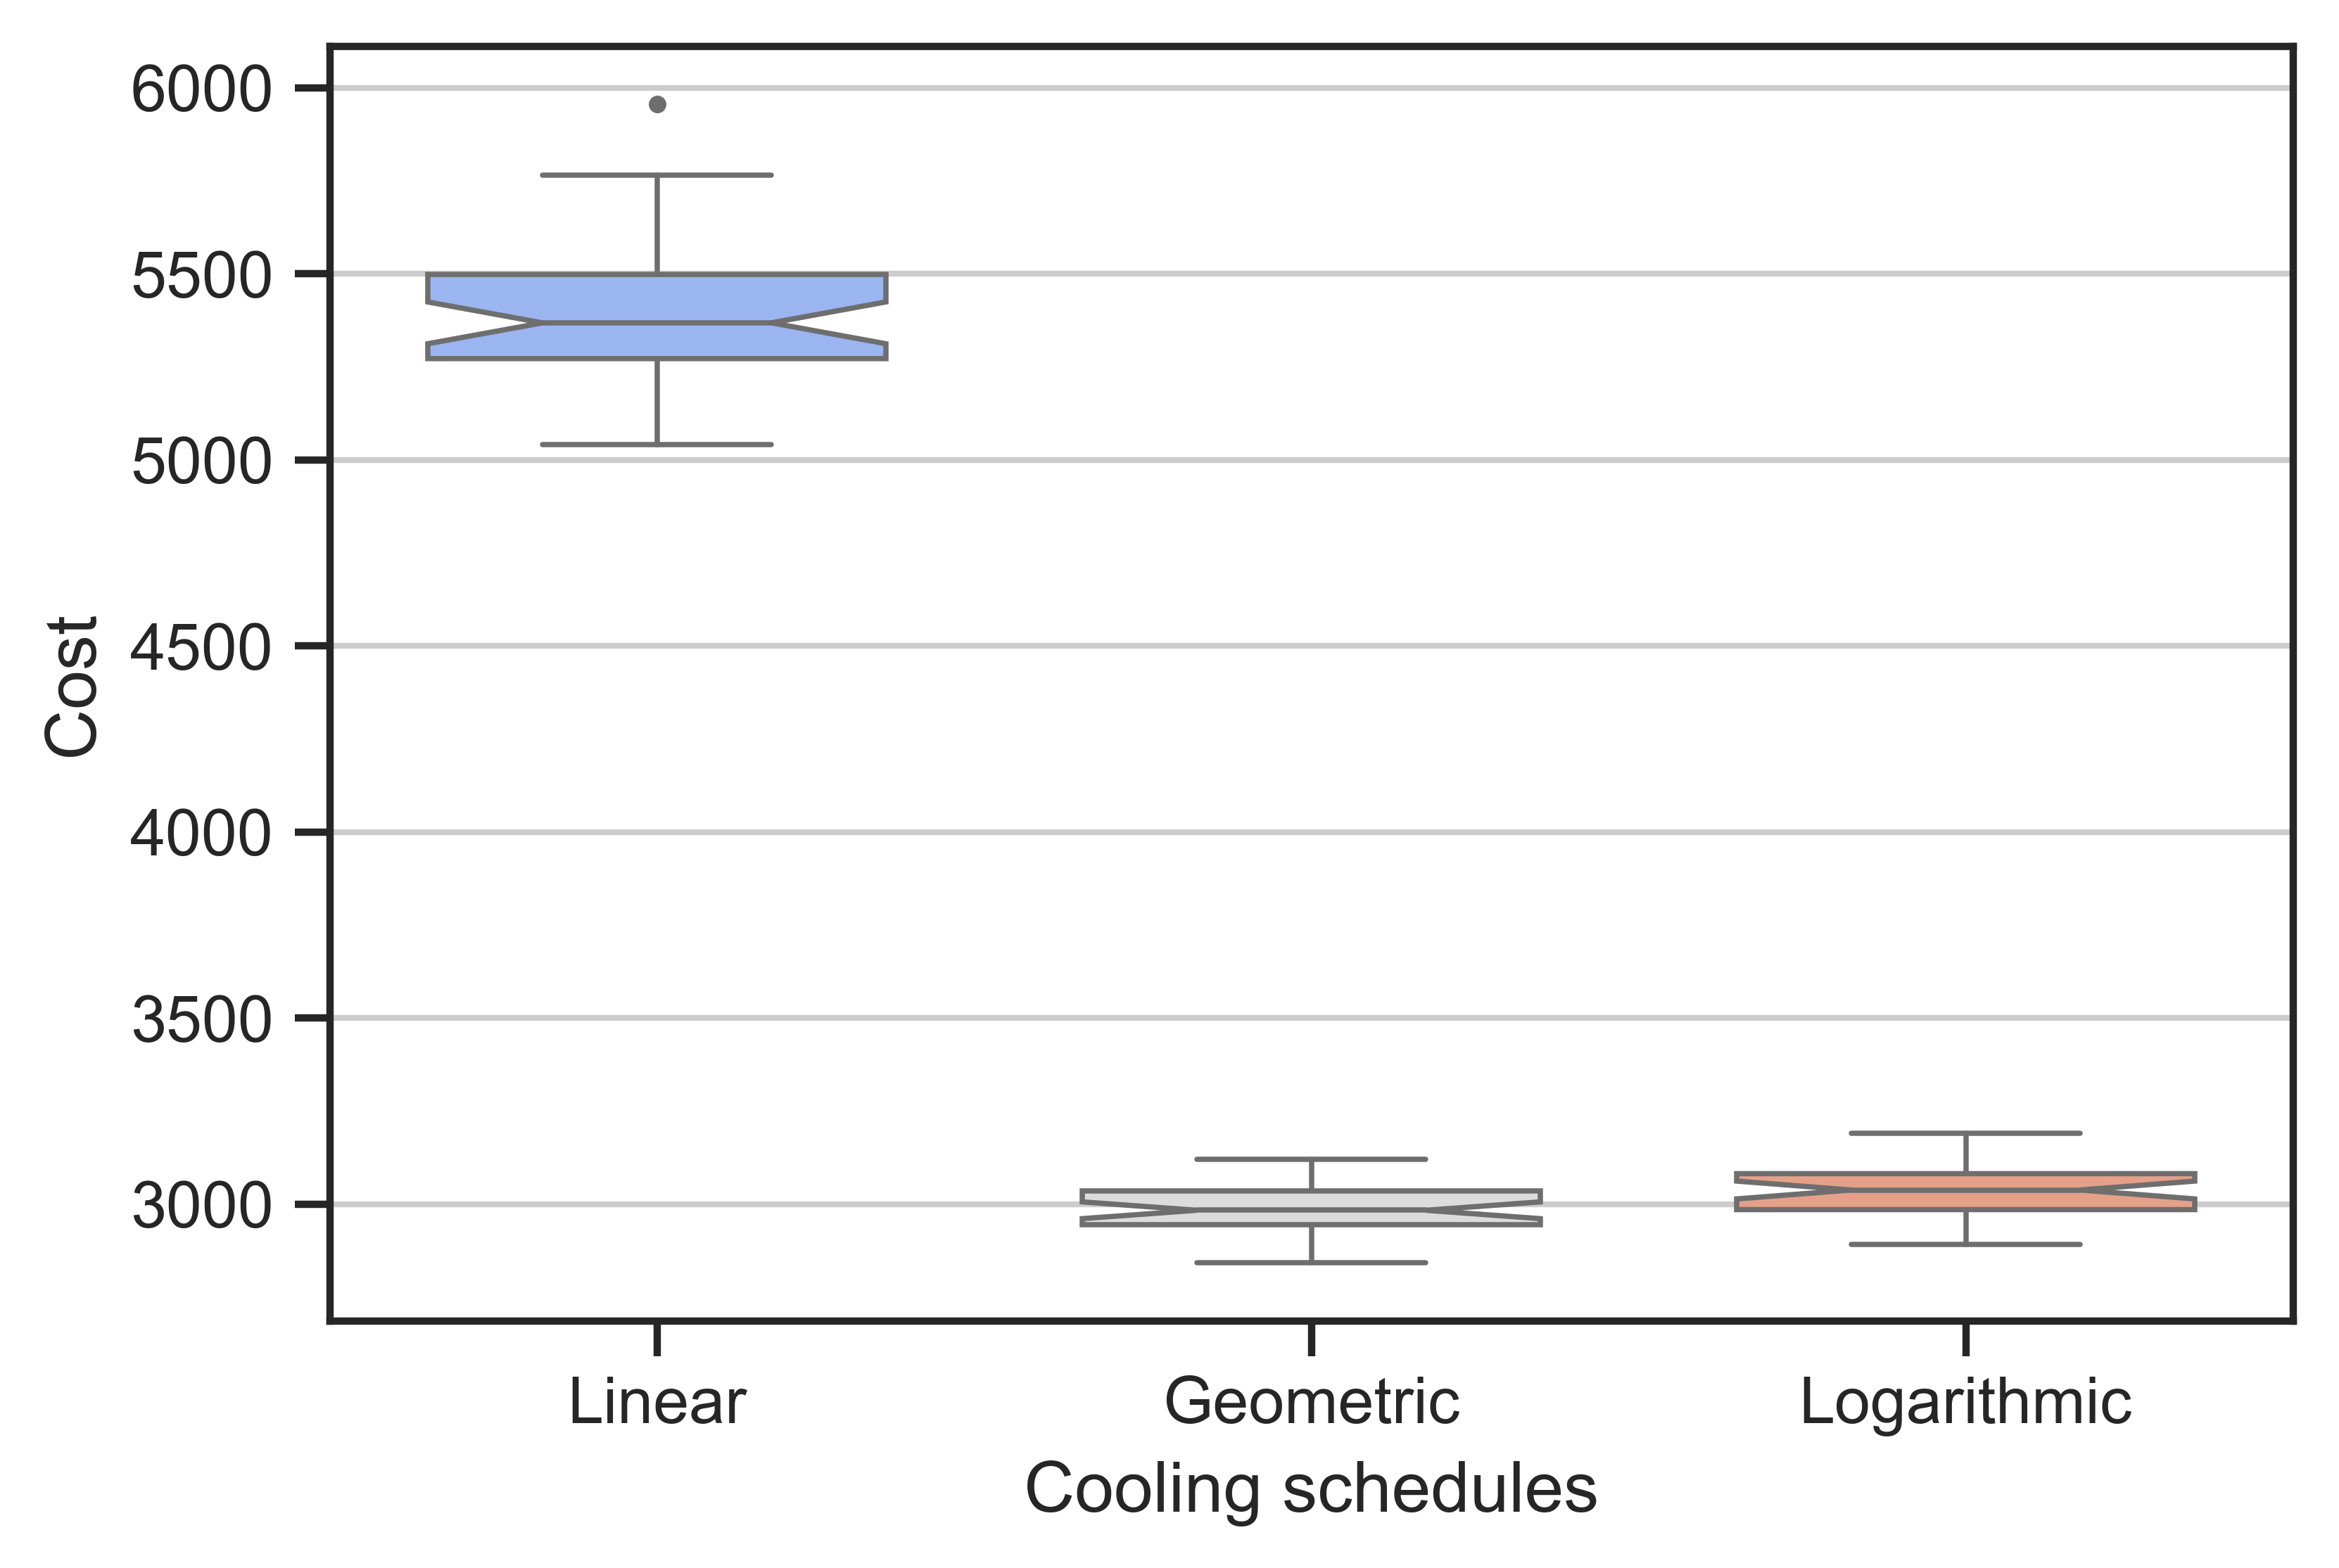

In [156]:
three_cooling_boxplot(simulated_data = "comparison_2.npz", title = "Three_cooling_comparison.pdf")

## Additional analytical plots

In [121]:
def boltzmann(H, T):
    """
    TODO:
    
    """
    return np.exp(-H/T)

In [126]:
def original_bolzman(title):
    """
    TODO: what plots?
    
    """

    rng = first(generate_rngs(1))
    x = np.linspace(0,np.pi,500)
    y = ((np.sin(4*x) + np.sin(7*x)))**2 + rng.normal(loc = 0, scale = 0.1, size = 500)
    plt.xlabel("x", size = 13) 
    plt.ylabel("f(x)", size = 13) 
    plt.grid(alpha = 0.6)
    plt.plot(x,y)
    
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()

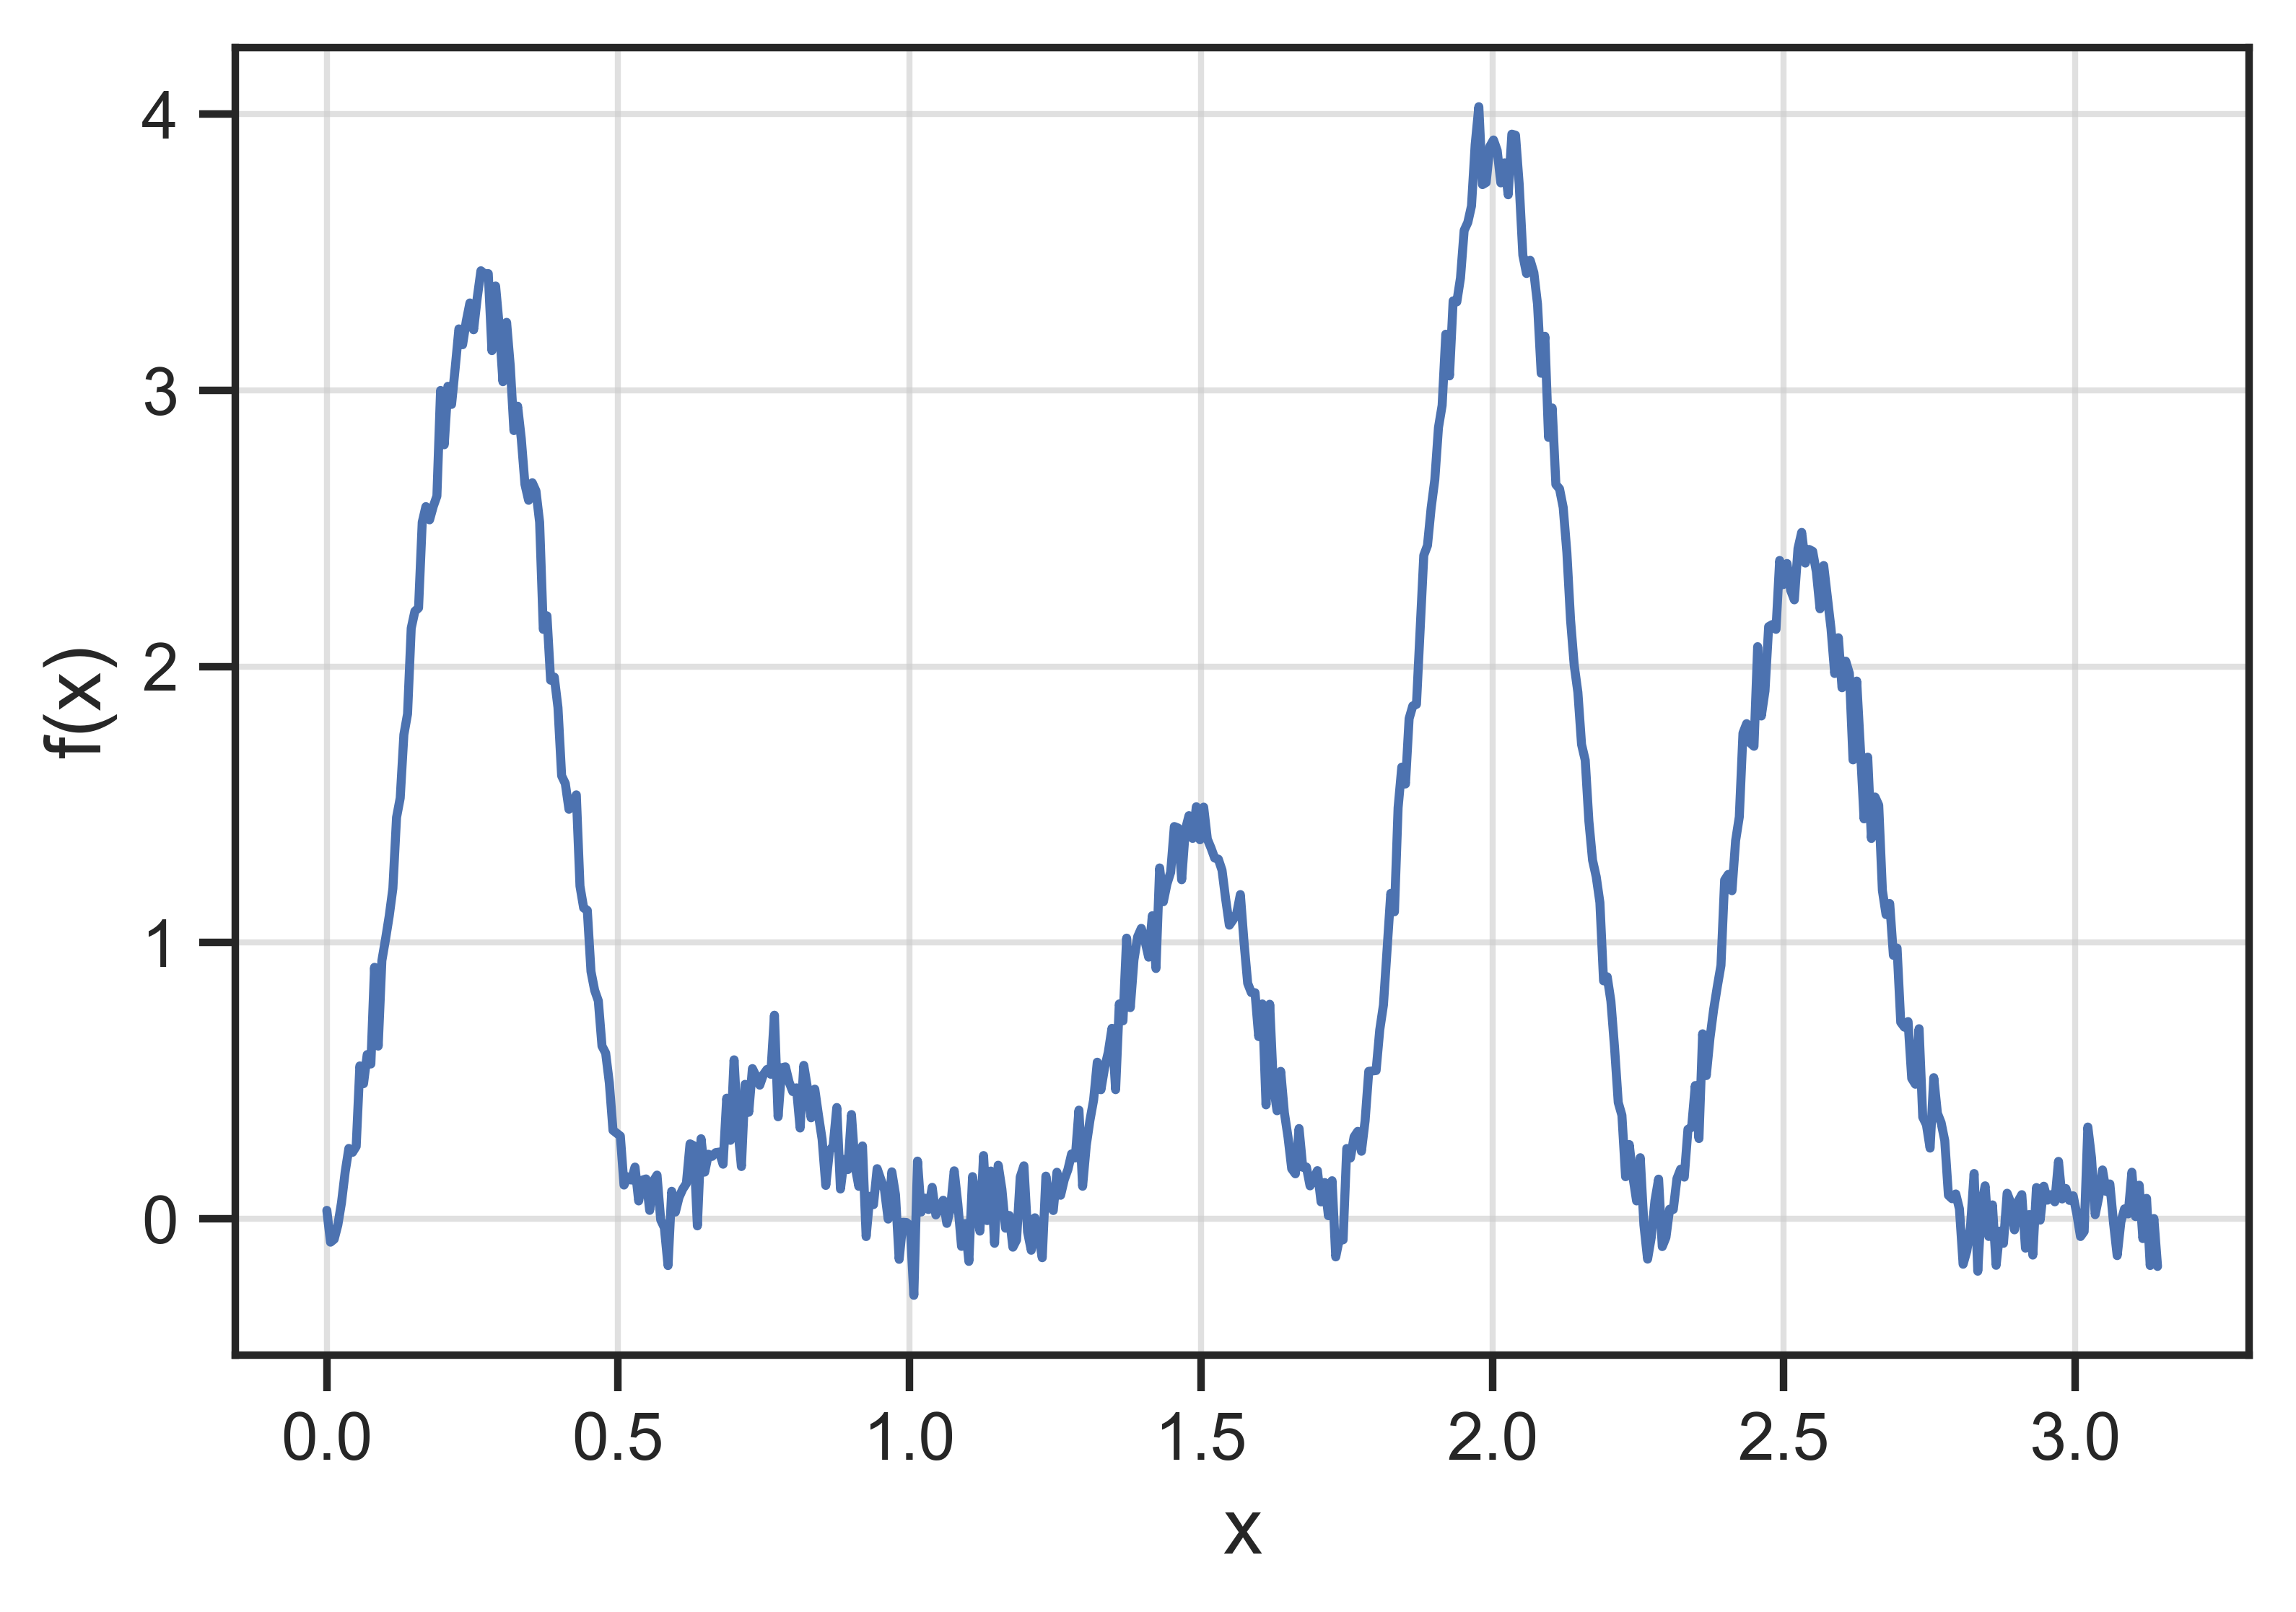

In [127]:
original_bolzman(title = "Original_bolzman.pdf")

In [139]:
def bolzman_different_Ts(temperature, title):
    """
    TODO: what plots?
    
    """
    T_values = np.logspace(-2, 3, 6, base = 10)
    y_boltzmann = [boltzmann(y, T) for T in T_values]
    
    if temperature == 1000:
        plt.plot(x, y_boltzmann[5], label = f"T = {T_values[5]}")
    if temperature == 100:
        plt.plot(x, y_boltzmann[4], label = f"T = {T_values[4]}")
    if temperature == 10:
        plt.plot(x, y_boltzmann[3], label = f"T = {T_values[3]}")
    if temperature == 1:
        plt.plot(x, y_boltzmann[2], label = f"T = {T_values[2]}")
    if temperature == 0.1:
        plt.plot(x, y_boltzmann[1], label = f"T = {T_values[1]}")
    if temperature == 0.01:
        plt.plot(x, y_boltzmann[0], label = f"T = {T_values[0]}")
    
    plt.xlabel("x", size = 15) 
    plt.ylabel("$e^{-f(x)/T}$", size = 15)
    plt.grid(alpha = 0.6)
    plt.legend()
    
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()

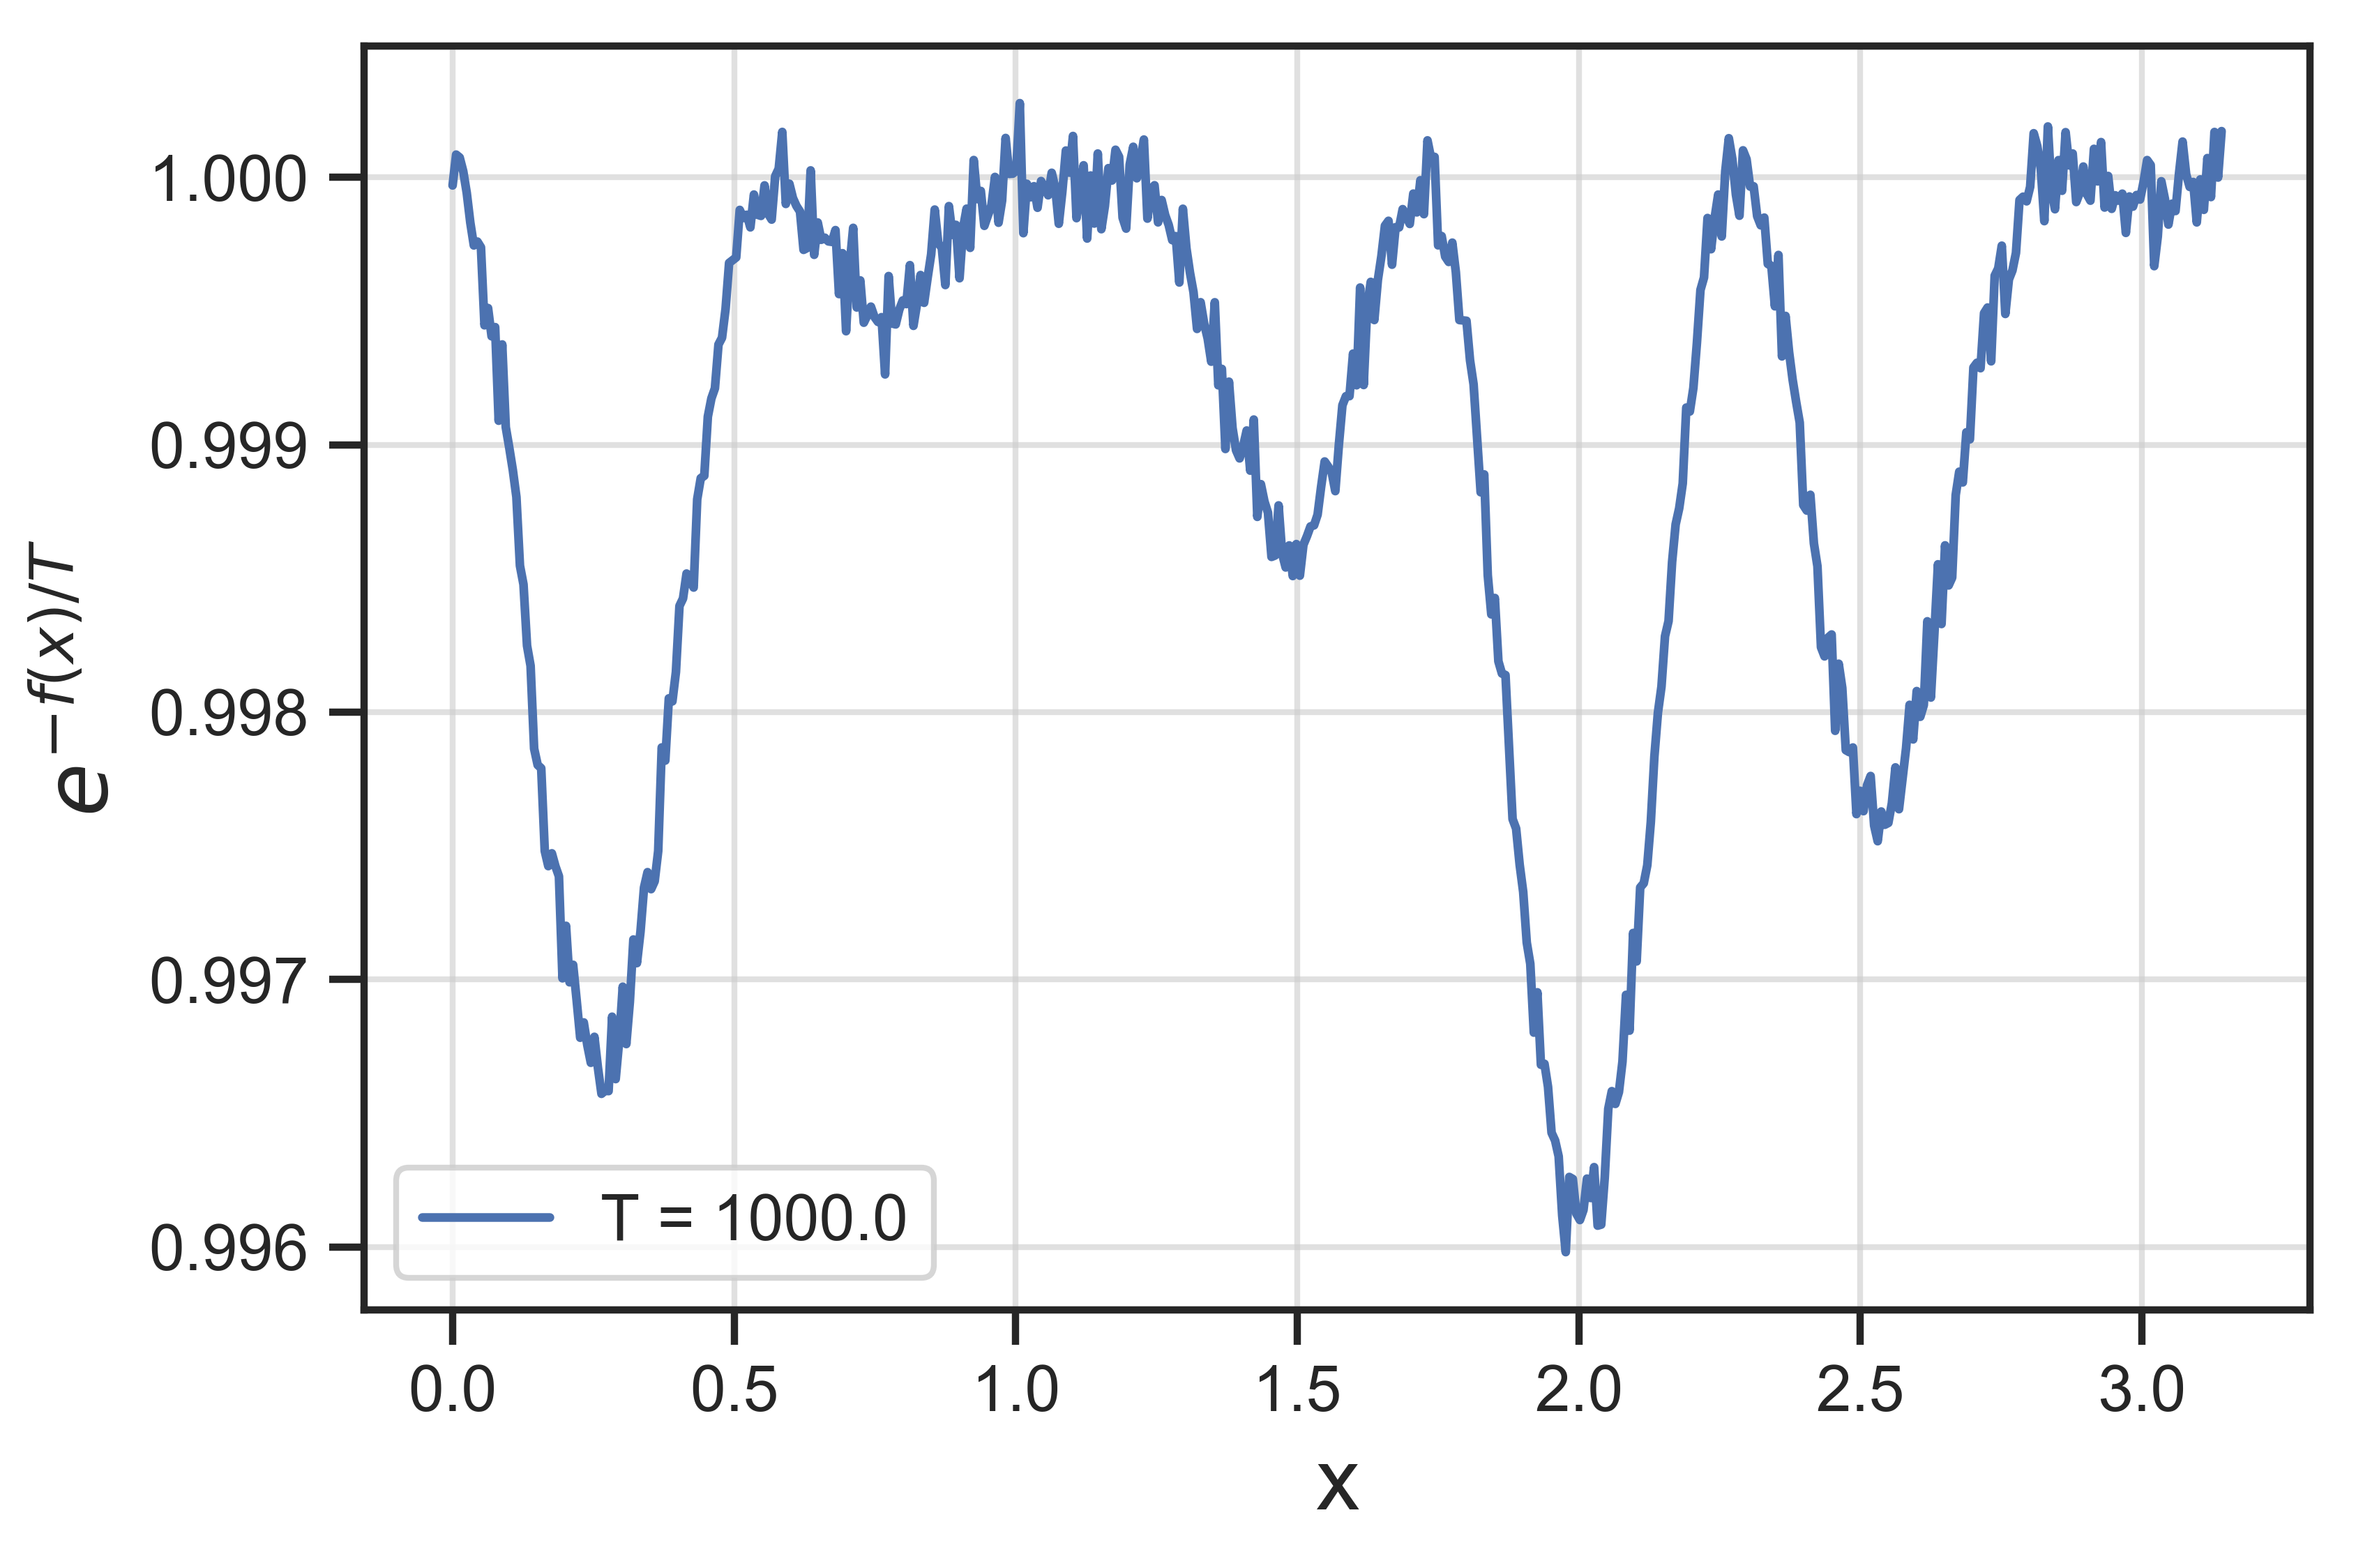

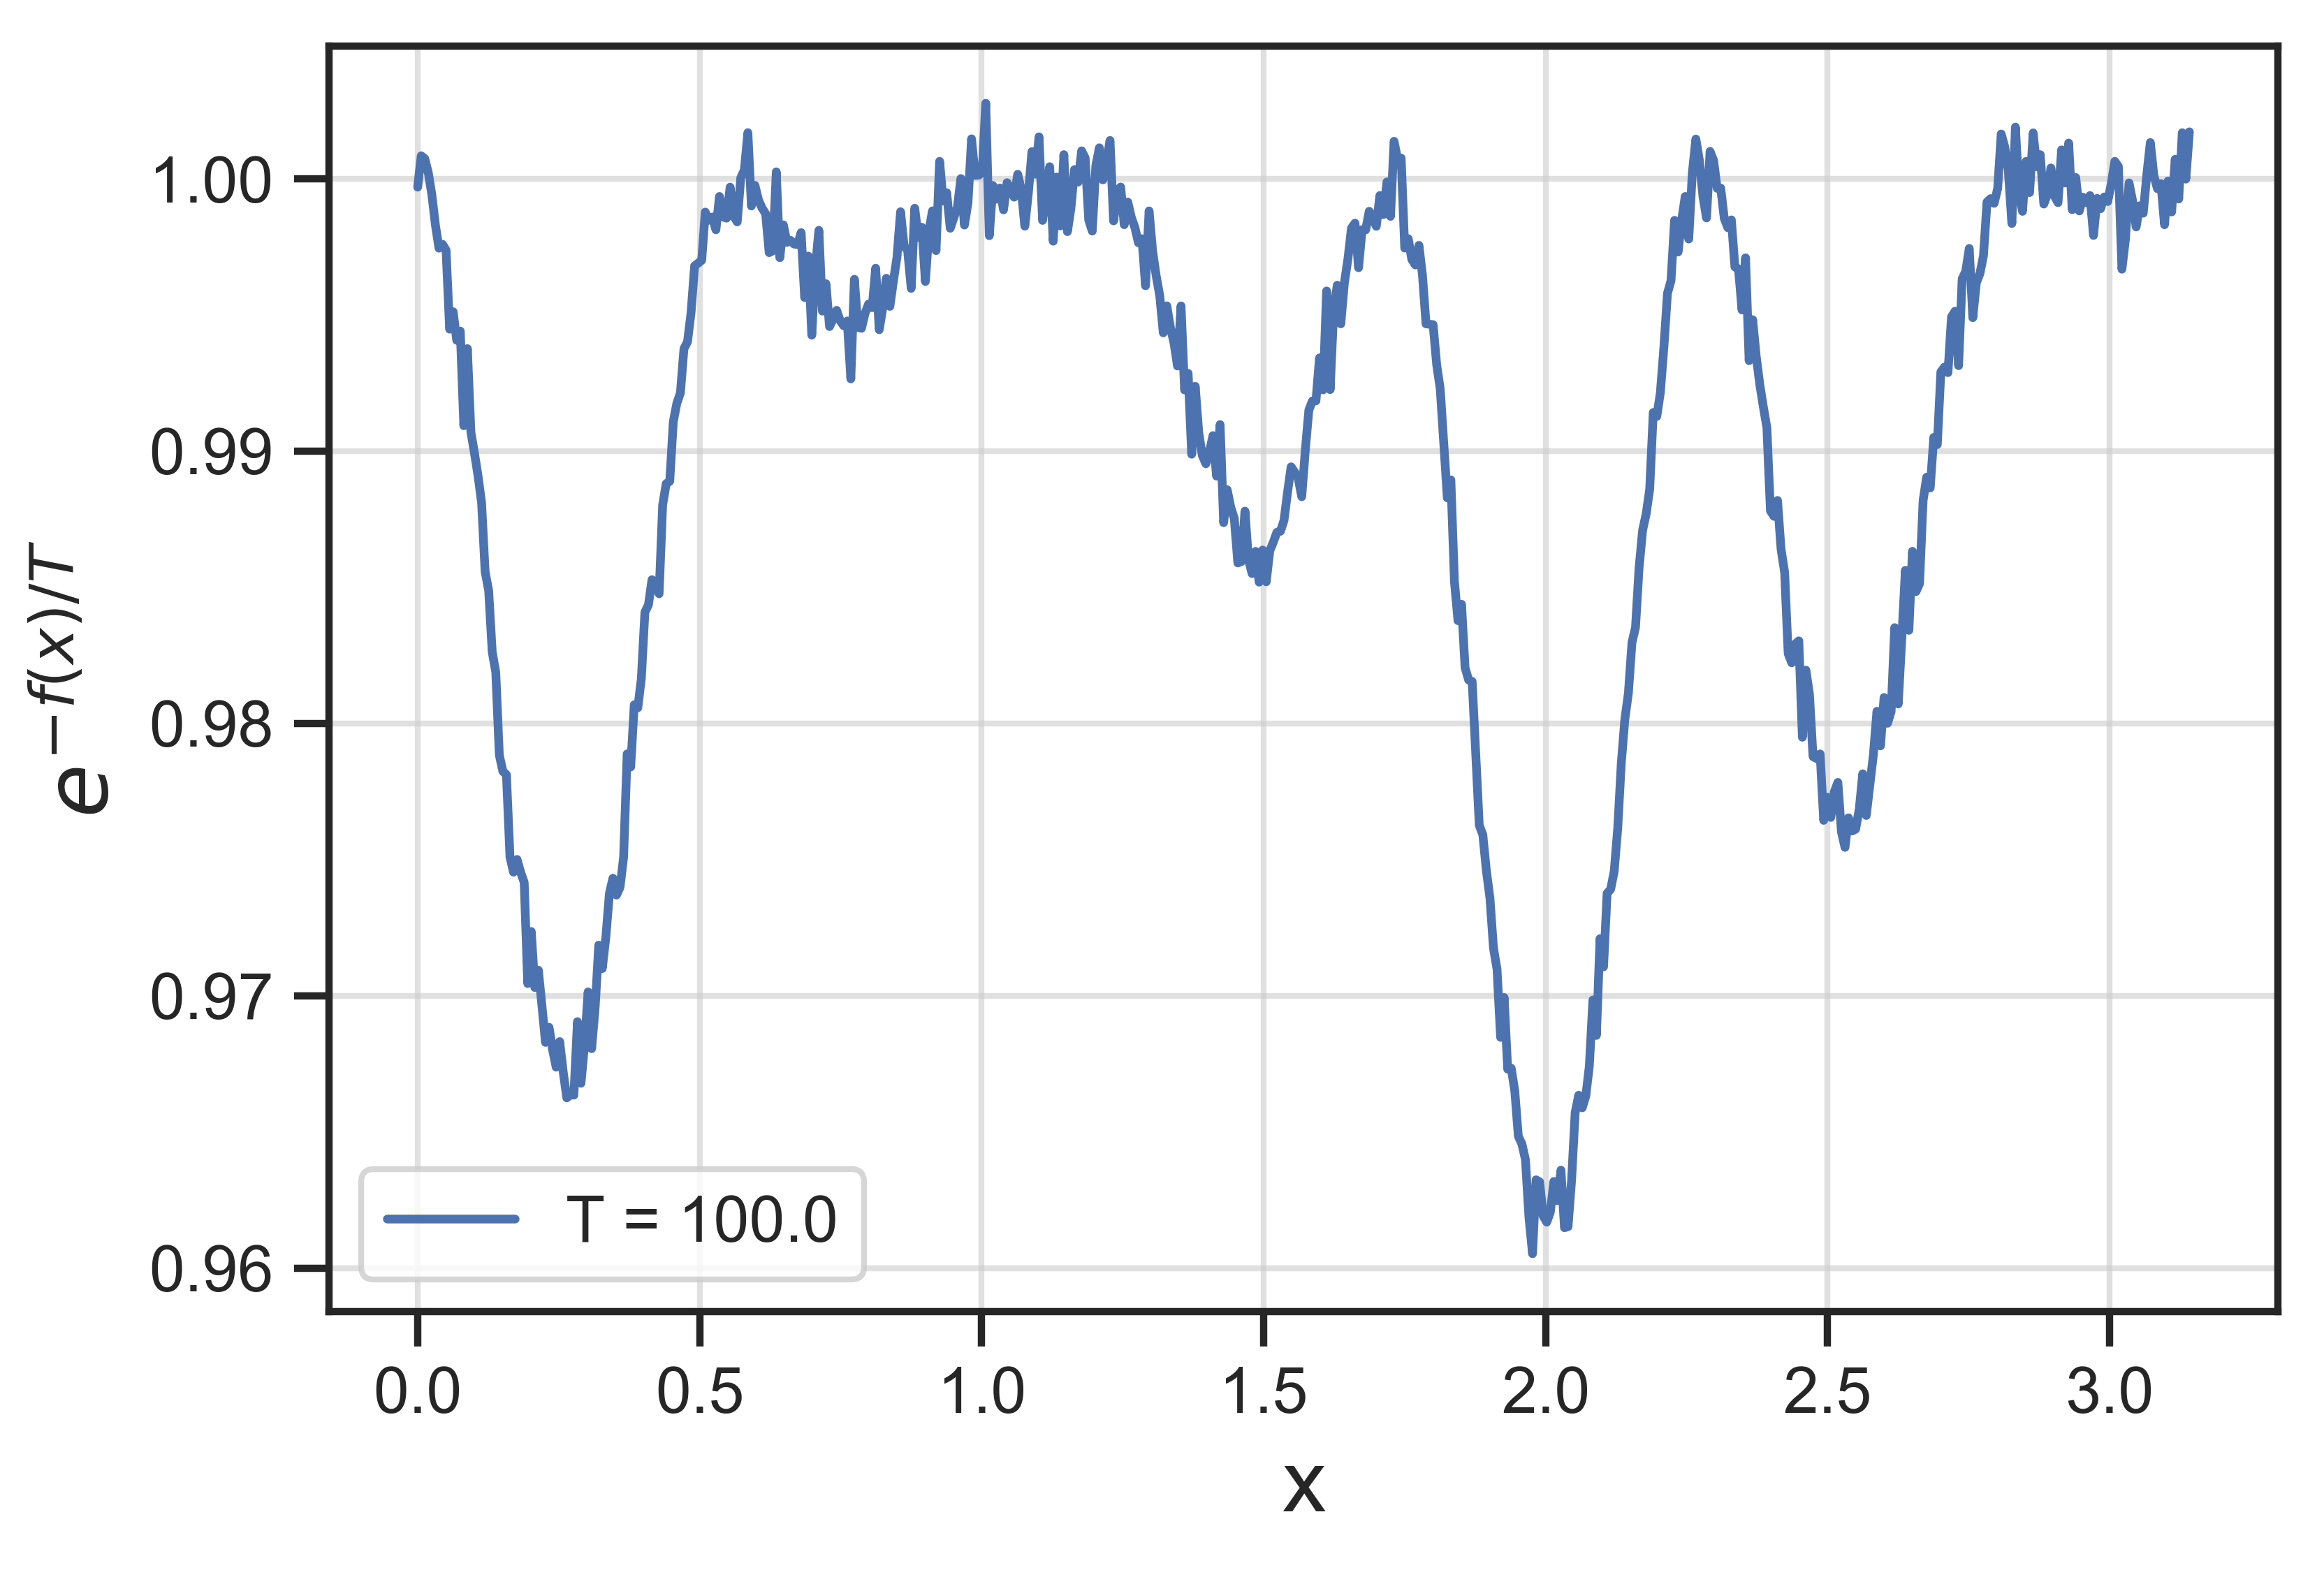

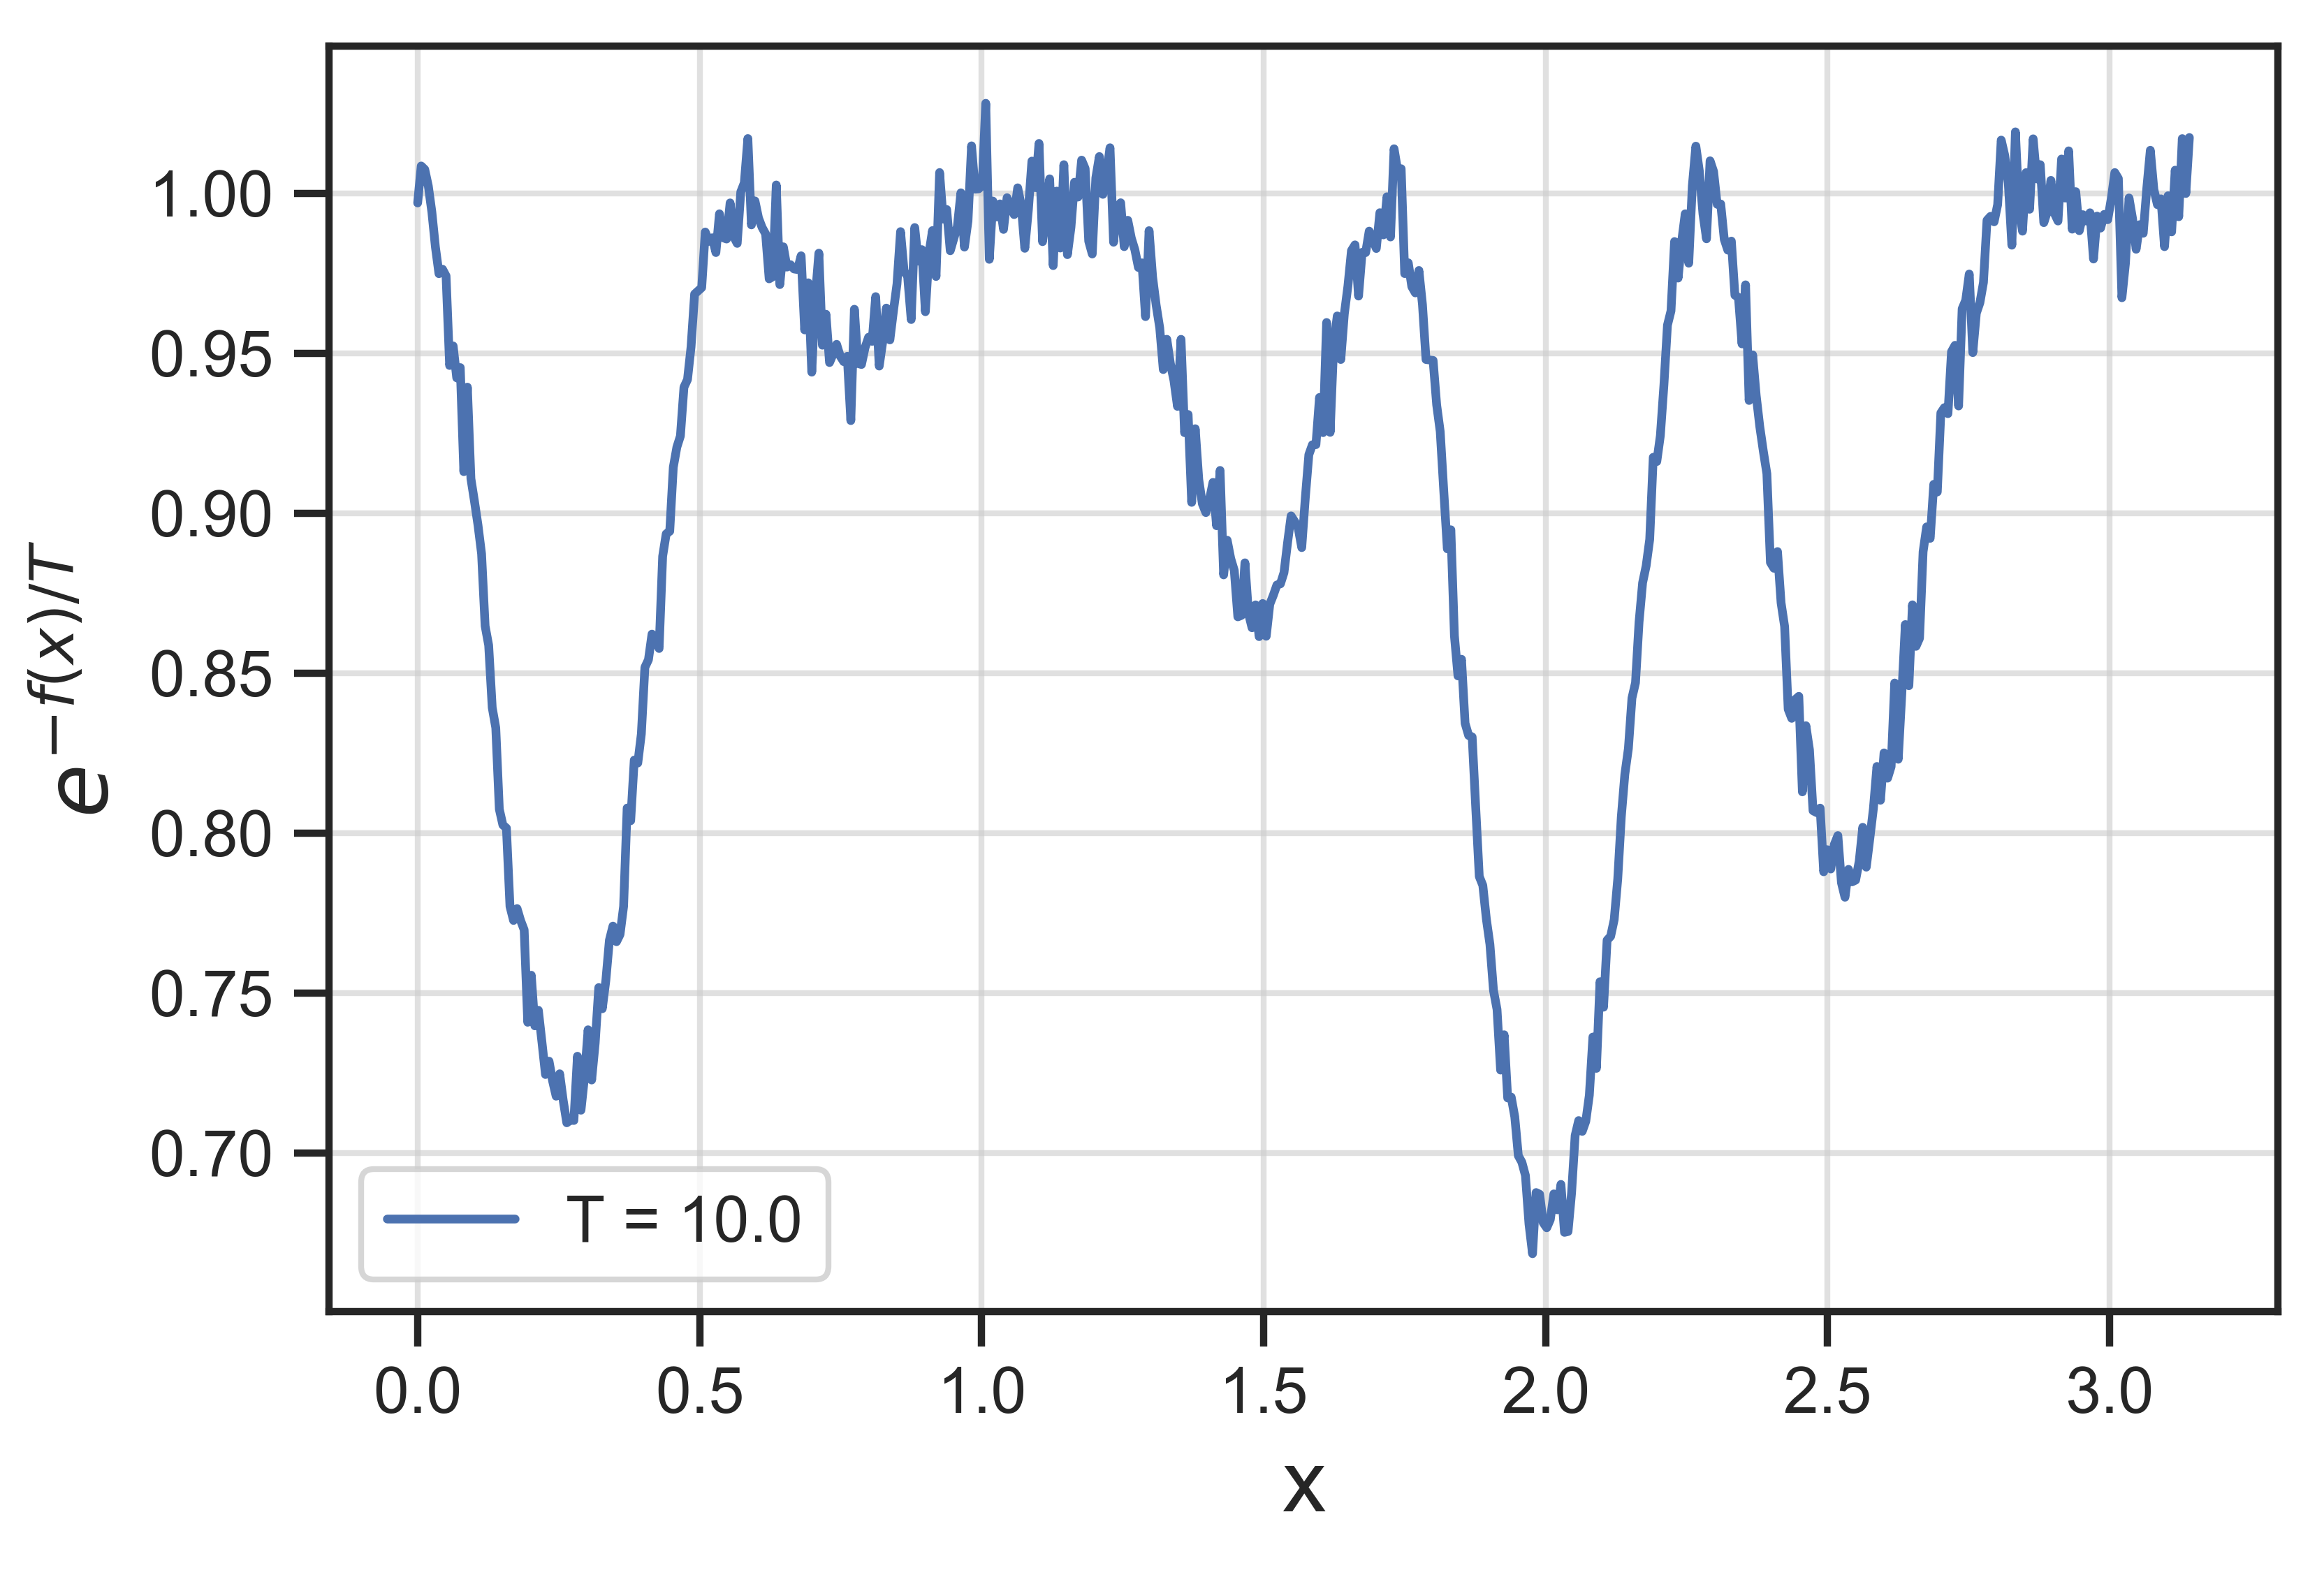

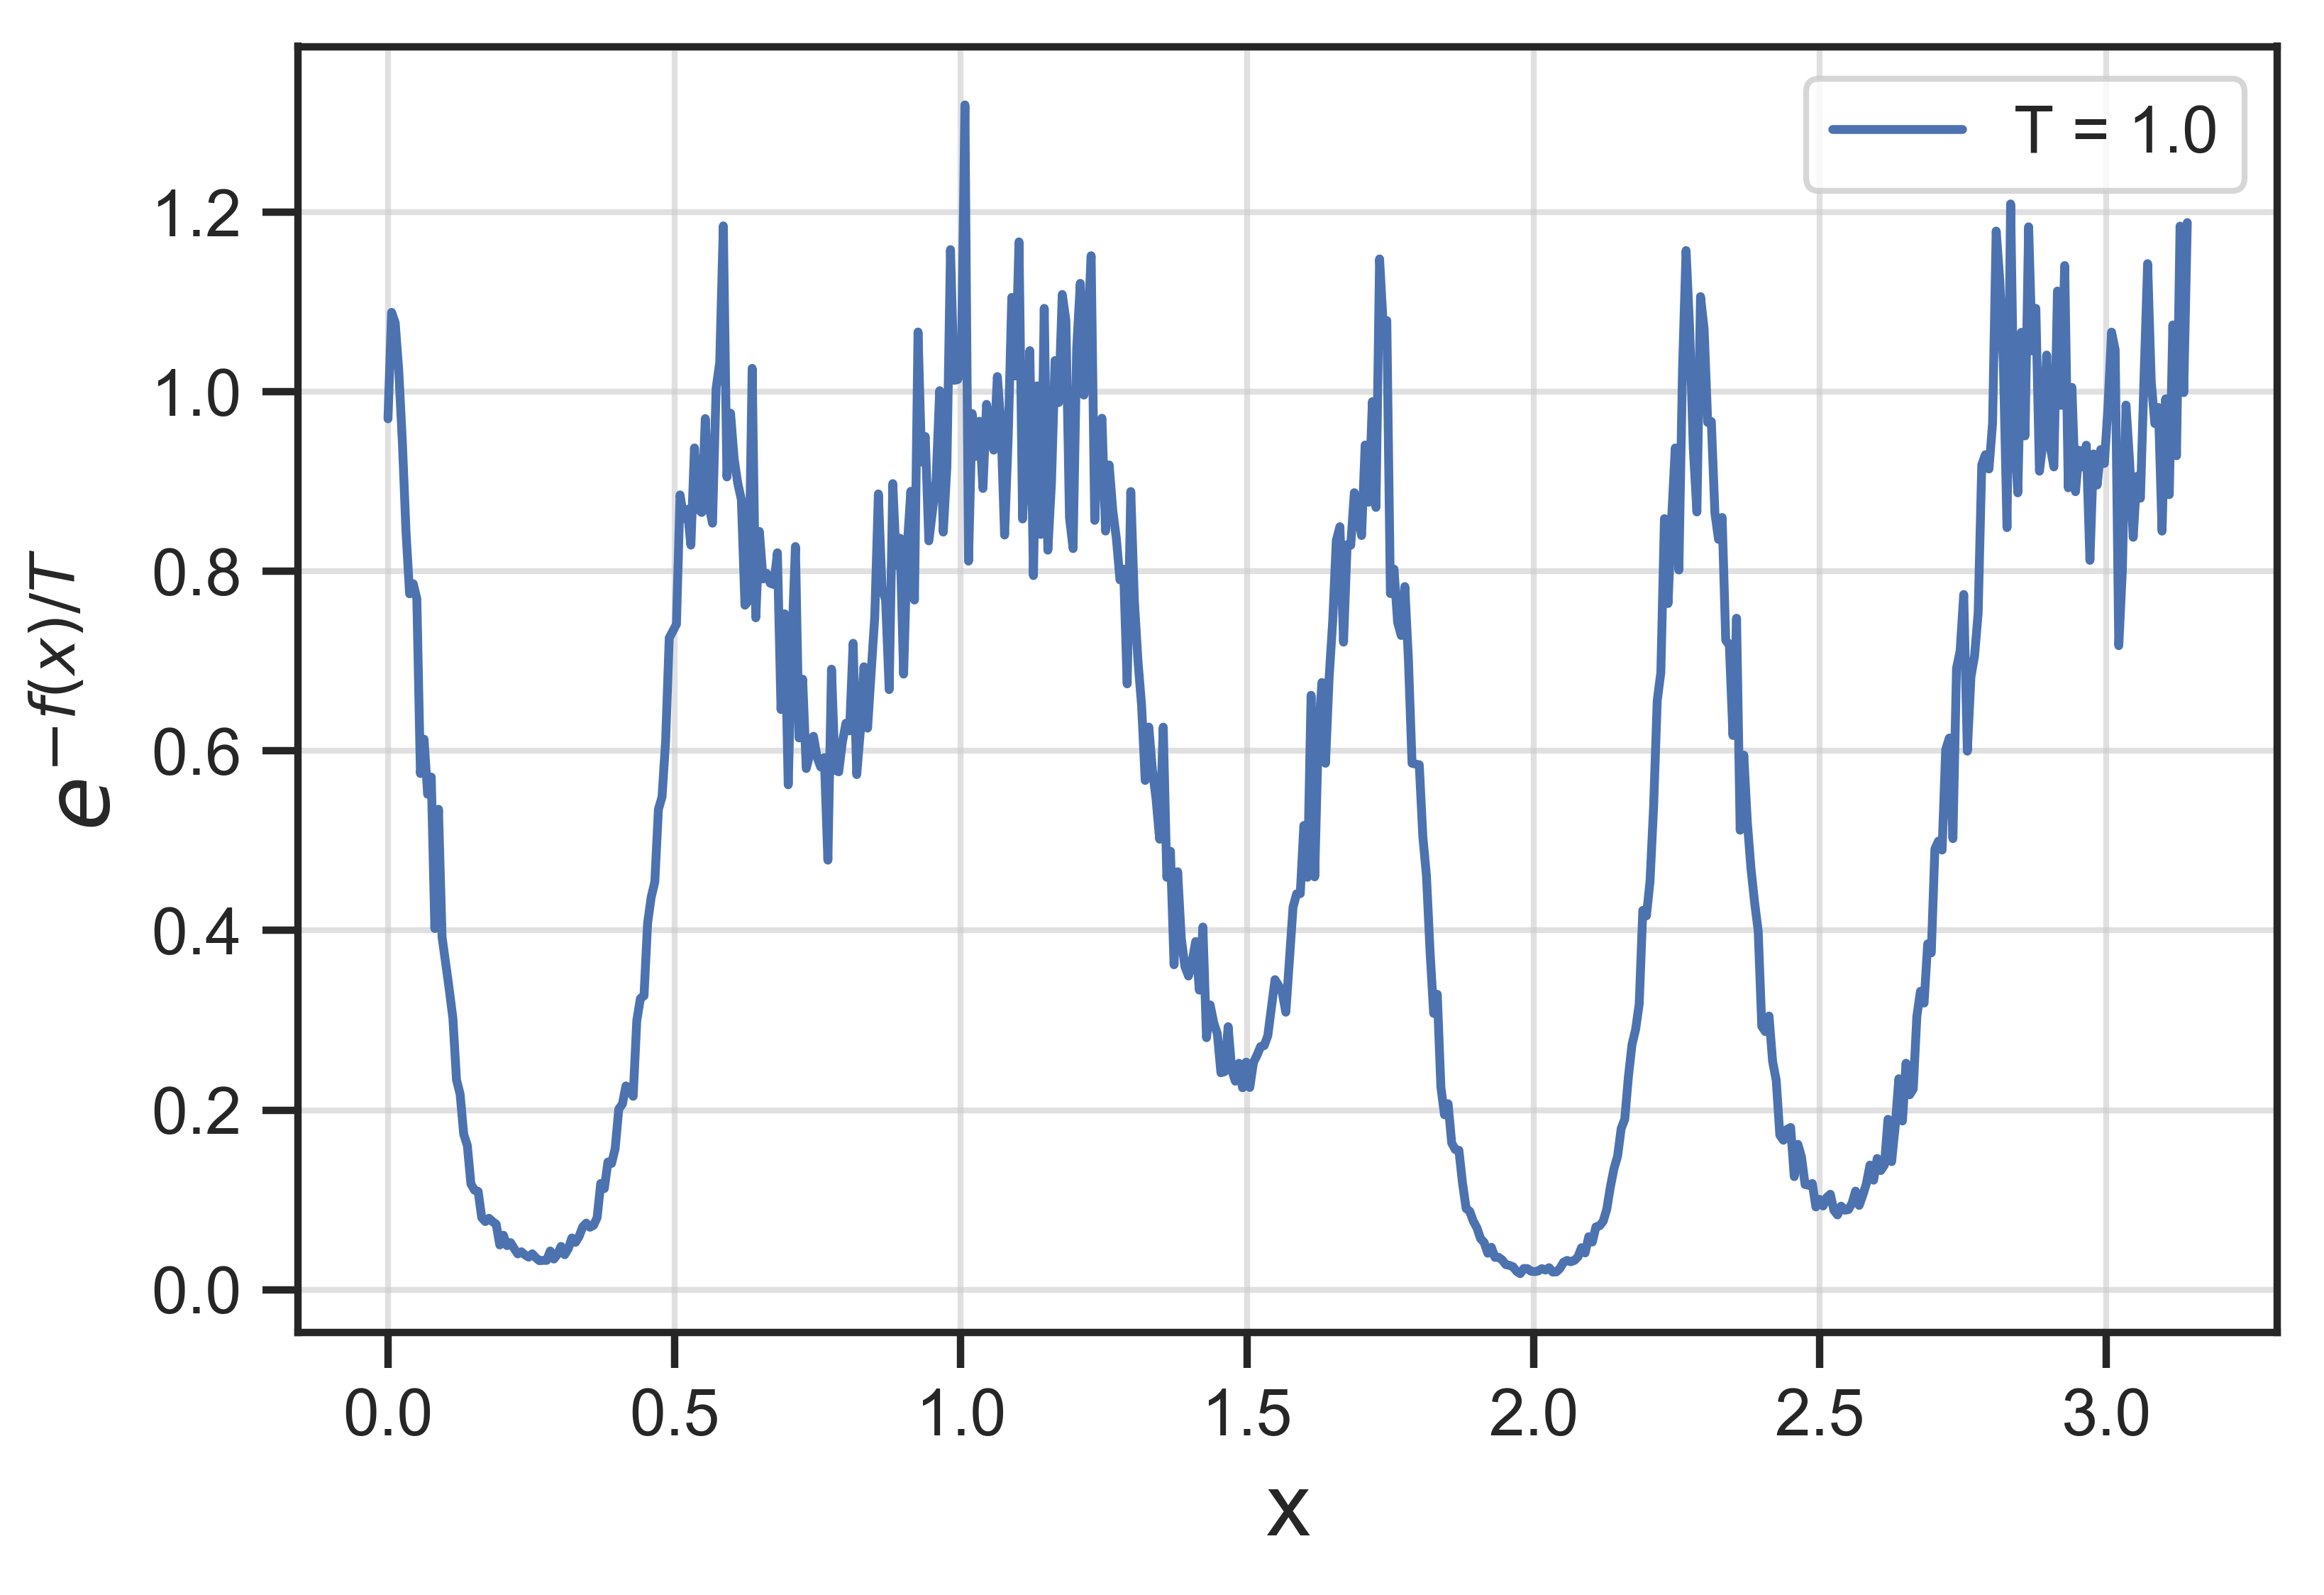

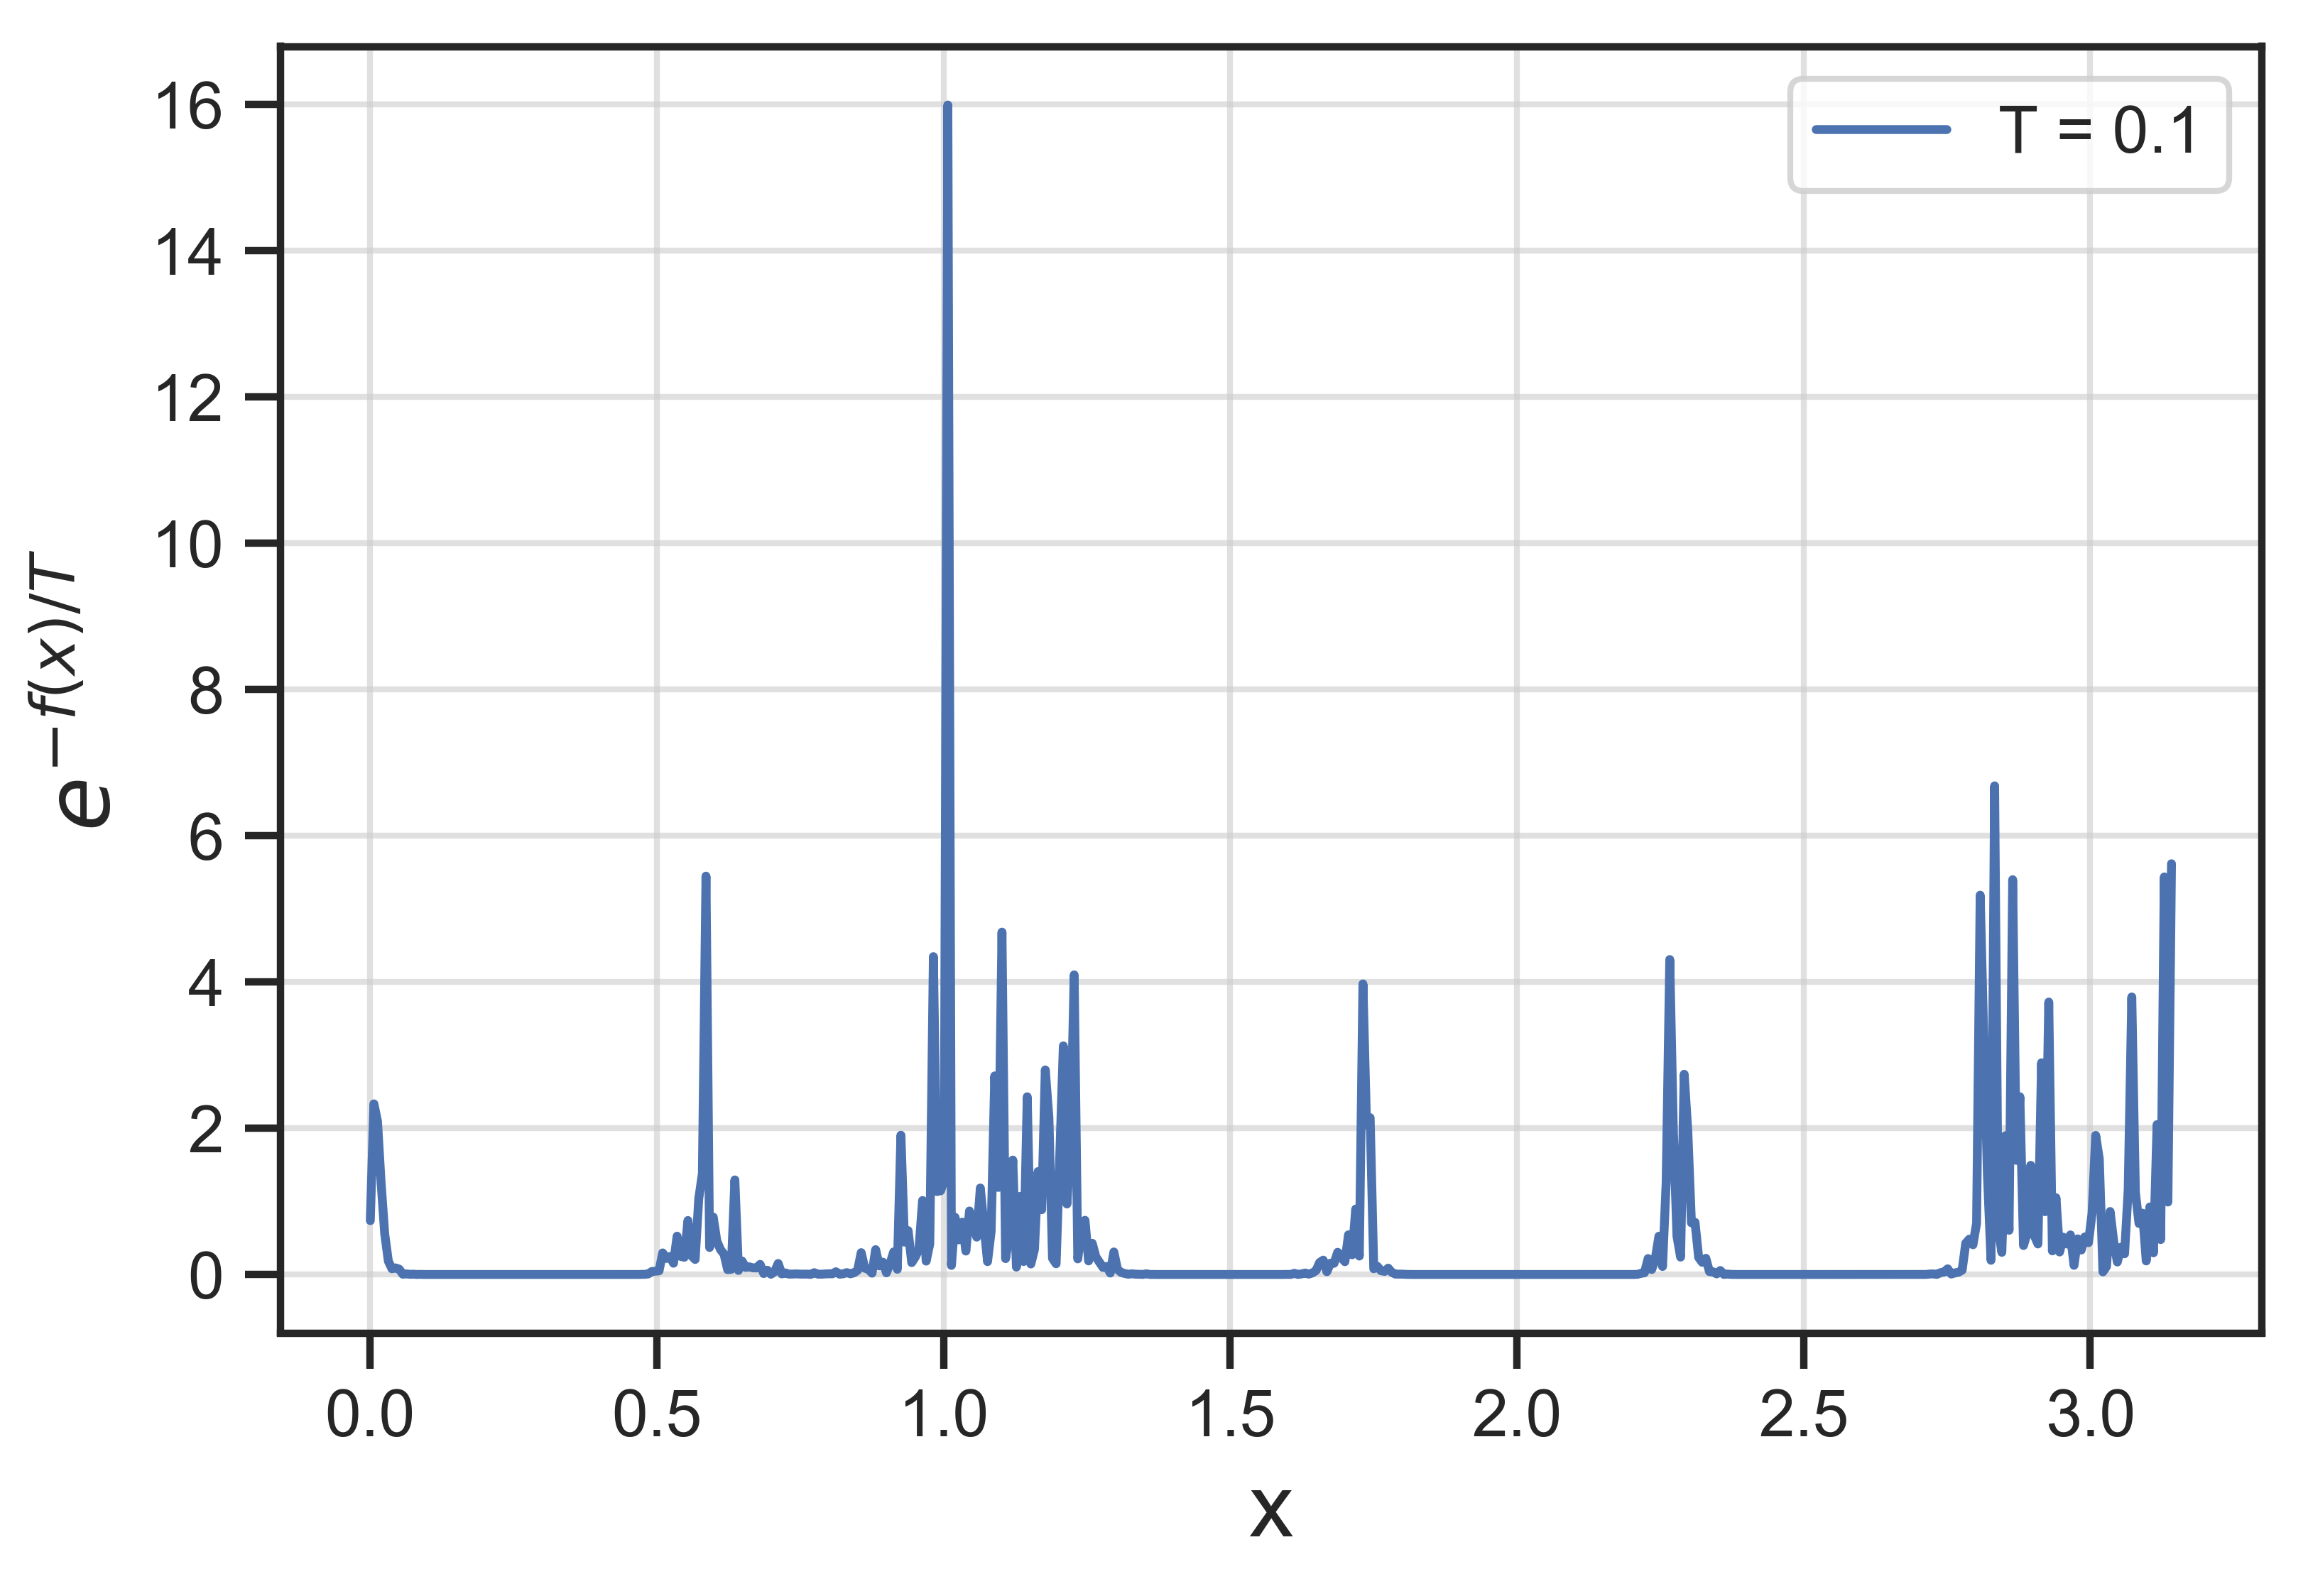

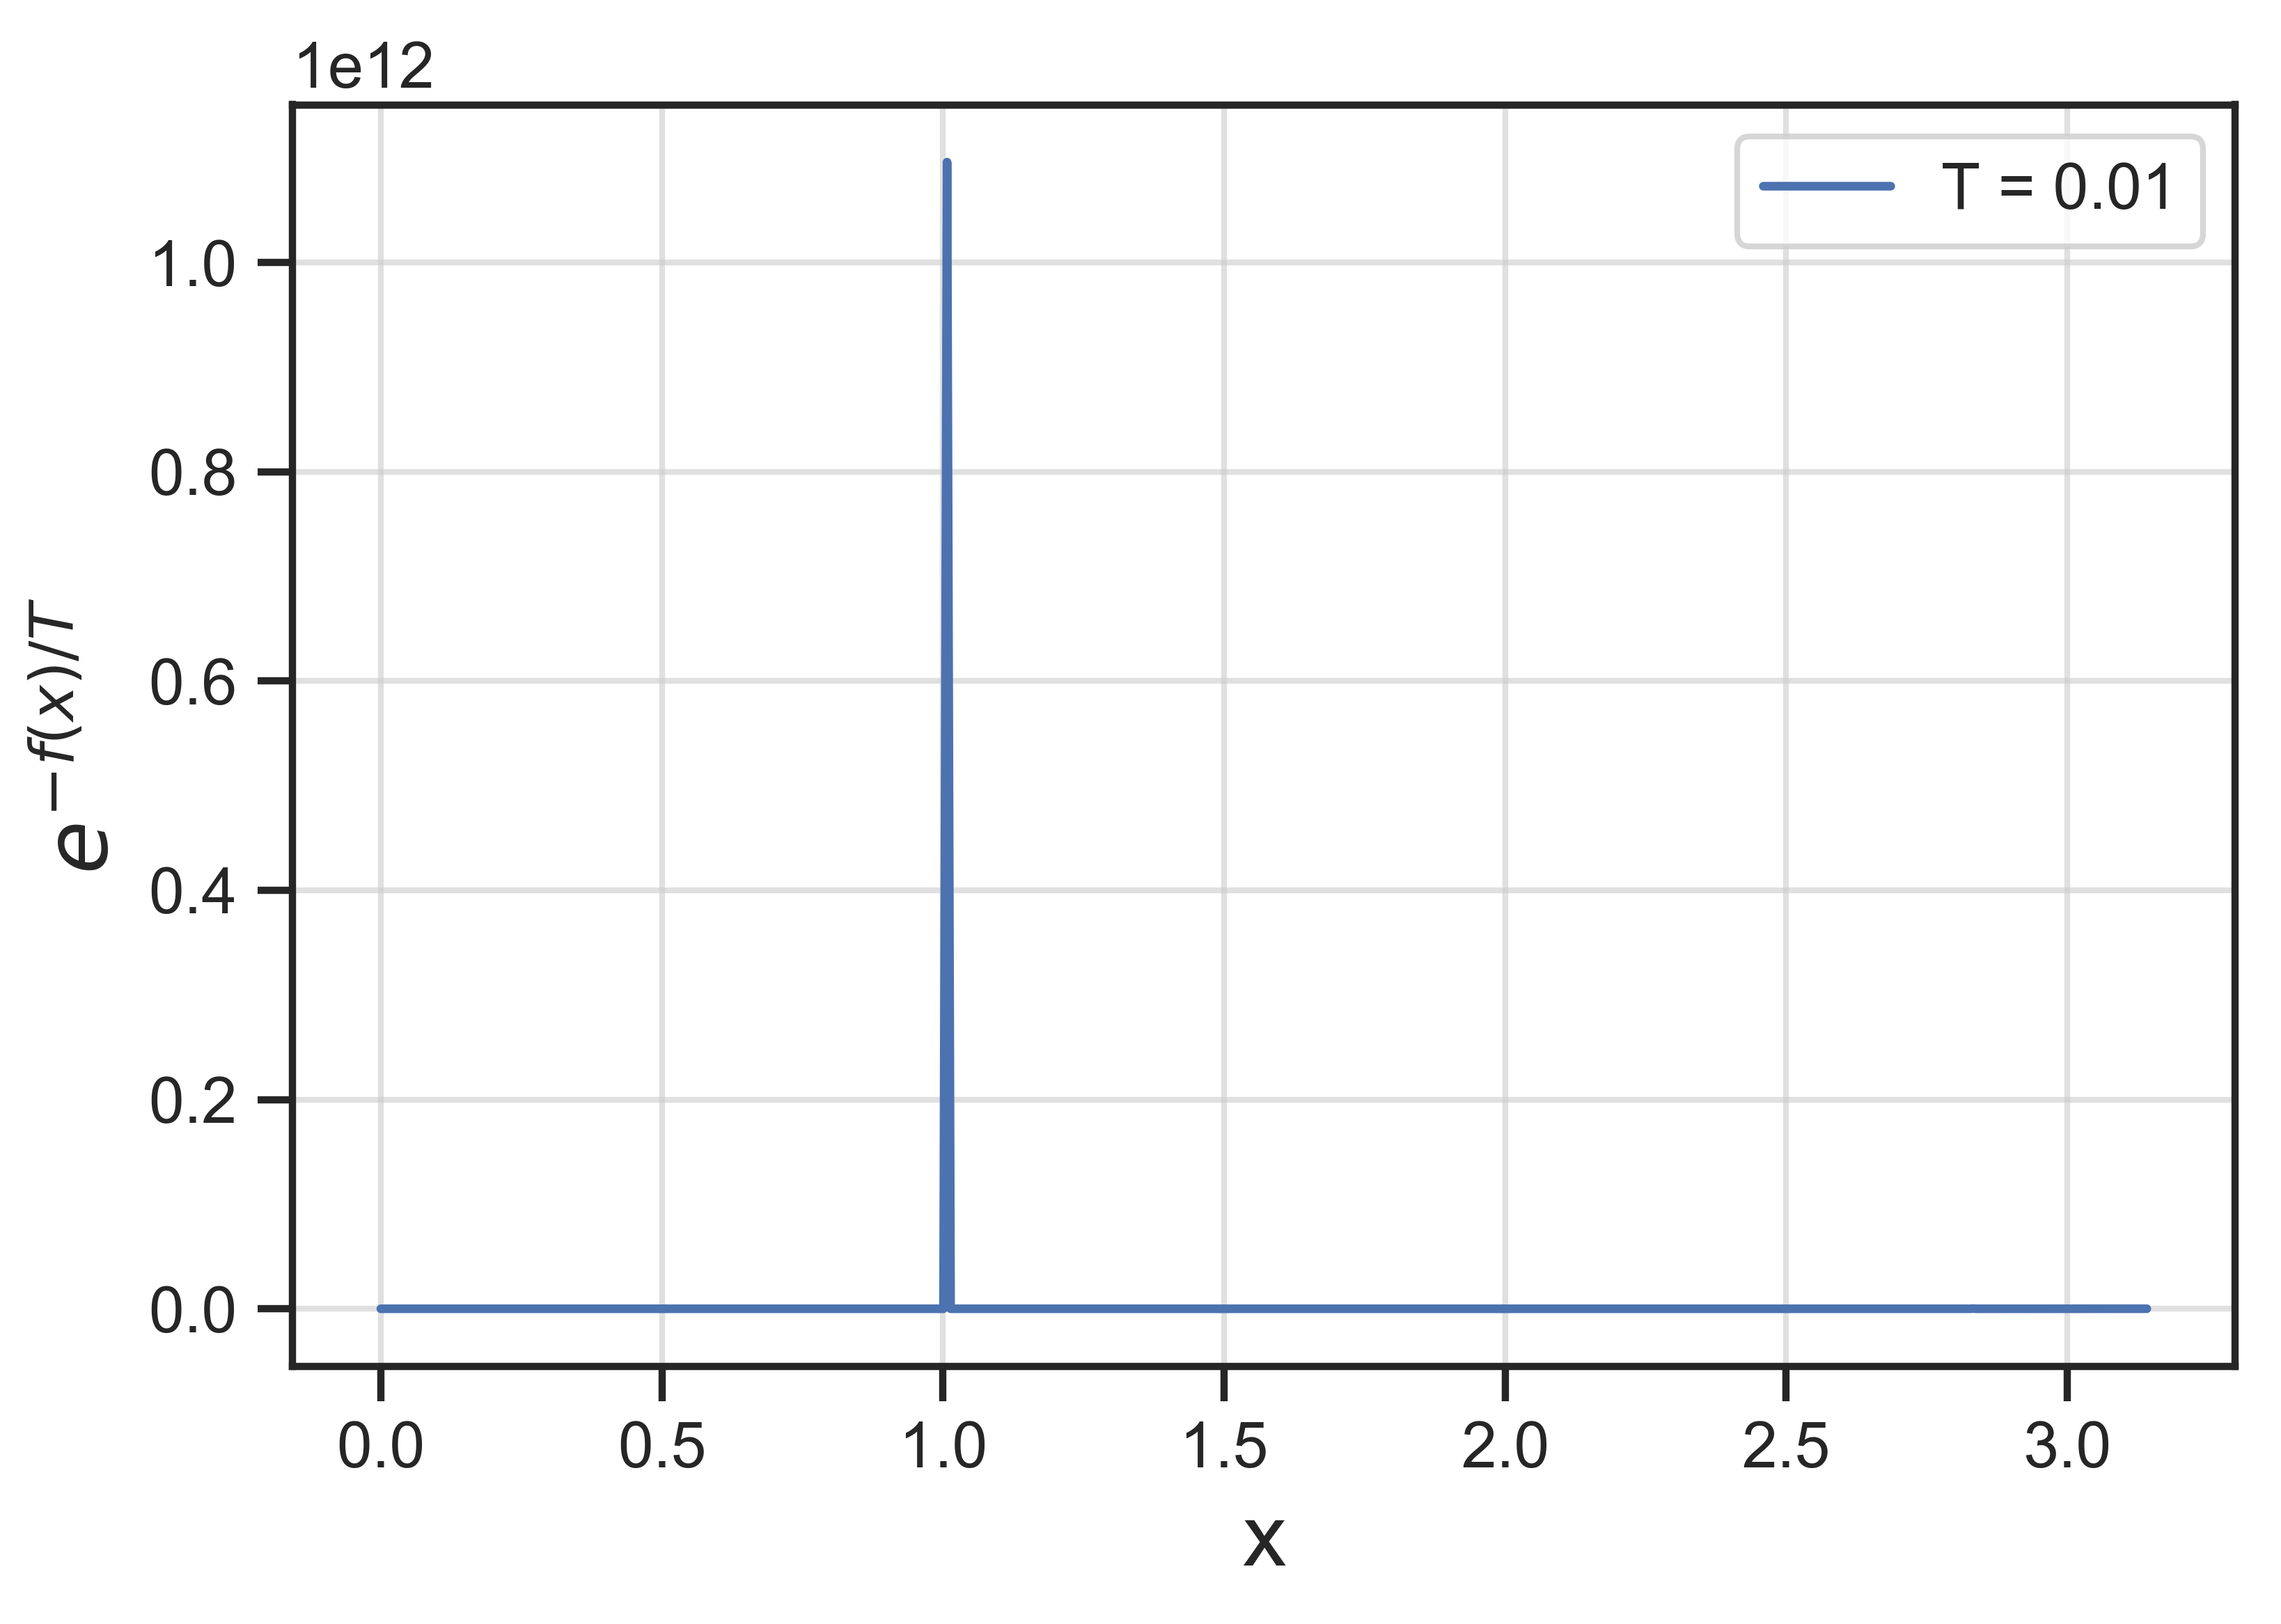

In [140]:
bolzman_different_Ts(temperature = 1000, title = "Bolzman_1000.pdf")
bolzman_different_Ts(temperature = 100, title = "Bolzman_100.pdf")
bolzman_different_Ts(temperature = 10, title = "Bolzman_10.pdf")
bolzman_different_Ts(temperature = 1, title = "Bolzman_1.pdf")
bolzman_different_Ts(temperature = 0.1, title = "Bolzman_01.pdf")
bolzman_different_Ts(temperature = 0.01, title = "Bolzman_001.pdf")
